In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction
from statsmodels.tsa.stattools import adfuller
from collections import Counter
from graphviz import Digraph

In [2]:
def links_selection(df,external_var,target_var, internal_var, tau_min=0, tau_max=14):
    '''
    external_var: list of all external variables
    target_var: list of targe variable e.g. Target NCE
    internal_var: list of all internal variables
    '''
    selected_links = {}
    var_set = list(df.columns) 
    for j in range(len(var_set)):
        if j in [var_set.index(idx) for idx in target_var+internal_var]:
            selected_links[j] = [(var,-lag) for var in [var_set.index(idx2) for idx2 in internal_var + external_var]                   
                         for lag in range(tau_min, tau_max + 1)]
        else:
            selected_links[j] = []
    return selected_links

def delete_variable(df, tau_max):
    var = []
    y_cut = []
    for idx in df.columns:
        y = np.array(df[idx])
        for i in range(2*tau_max+1):
            y_cut = y[2*tau_max-1-i:len(y)-1-i]
            standard = (y_cut - y_cut.mean())/y_cut.std()
            if np.isnan(standard).sum()!=0:
                var.append(idx)
    return df.drop(var,1)

def tau_max_selection(correlation_list):
    y = np.argmax(abs(correlation_list),axis = 2)
    y_2 = list(y.reshape(len(y)**2))
    tau_count = max(set(y_2), key=y_2.count)
    counter = Counter(y_2)
    if tau_count==0:
        tau_count = counter.most_common()[1][0]
    return tau_count

def DAG_plot_for_all_diff(df_test,independence_test ='parcorr',NCE_type = 'issuer',
             tau_max = 14, alpha = 0.01, file_name = None,delete_conflict_links=False, 
                          link_name = 'link',p_name = 'p_value'):

    df = delete_variable(df_test,tau_max)
    dataframe = pp.DataFrame(df.values, var_names=list(df.columns))
    if independence_test == 'parcorr':
        parcorr = ParCorr(significance='analytic')
        pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
    elif independence_test == 'GPDC':
        gpdc = GPDC(significance='analytic', gp_params=None)
        pcmci = PCMCI(dataframe=dataframe, cond_ind_test=gpdc,verbosity=1)
    elif independence_test == 'cmi_knn':
        cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks')
        pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cmi_knn,verbosity=1)

    pcmci.verbosity = 2
    if NCE_type == 'issuer':
        target = ['entropy_i']
    elif NCE_type == 'participate':
        target = ['entropy_p']
    elif NCE_type == 'tasktype':
        target =['NCE_t']

    if len(df.columns) == 9:
        external = []
    else:
        external = [i for i in df.columns[9:]]
    selected_links = links_selection(df,external,target,['issuer','users','covid_topic','education_topic'
                        ,'environment_topic','reopen_topic','transportation_topic','volunteering_topic'],tau_min = 0,tau_max = tau_max)
    results = pcmci.run_pcmciplus(selected_links = selected_links, tau_min=0, tau_max=tau_max, pc_alpha=alpha,conflict_resolution = True)
    q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh', exclude_contemporaneous=True)
    link_matrix = results['graph']
    #print(results['p_matrix'])
    
    
    if delete_conflict_links:
        pos = np.where(link_matrix[:, :, 0] == "x-x")
        for i in range(4):
            for j in range(pos[0].shape[0]):
                x = pos[0][j]
                y = pos[1][j]
                link_matrix[x, y, i] = ""
    np.save(link_name,link_matrix)
    #np.save(value_name,results['val_matrix'])
    np.save(p_name,results['p_matrix'])
    
    tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=list(df.columns),
    link_colorbar_label='Cross-MCI',
    node_colorbar_label='Auto-MCI',
    figsize = (10,10),
    node_size=0.3,
    #cmap_nodes = 'RdBu_r',
    save_name=file_name,
    curved_radius = 0.3,
    node_label_size = 9,
    arrow_linewidth = 10,
    ); #plt.show()

def used_node(link):
    s = []
    test = arrow_type(link)
    for i in range(len(test)):
        s.append(test[i][0])
        s.append(test[i][1])
    return list(set(s))
    
def color_selection(value):
    if value > 0:
        color_res = 'red'
    else:
        color_res = 'blue'
    return color_res

def arrow_type(links):
    res = []
    x,y,z = links.shape
    for i in range(x):
        for j in range(y):
            for k in range(z):
                if i != j:
                    if links[i,j,k] == '<--':
                        res.append((j,i,k))
                    elif links[i,j,k] == '-->':
                        res.append((i,j,k))
                    elif links[i,j,k] == 'o-o':
                        res.append((i,j,k))
                        res.append((j,i,k))
    return list(dict.fromkeys(res))

def graphviz_plot2(df,links,values,filename = 'example'):
    var = list(delete_variable(df,14).columns)
    col = list(df.columns)
    node_set = used_node(links)
    g = Digraph(filename, filename=None)
    g.attr(compound='true')
    m,n,k = links.shape
    if m > 9:
        with g.subgraph(name='cluster0') as c:
            for i in col[9:]:
                if i in [var[node] for node in node_set]:
                    c.node(i,i,color='red')
                else:
                    c.node(i,i,color='red',fillcolor='grey', style='filled')
    with g.subgraph(name='cluster1') as c:
        for inter in var[1:9]:
            if inter in [var[idx2] for idx2 in node_set if 0<idx2<9]:
                c.node(inter,inter,color='blue')
            else:
                c.node(inter,inter,color='blue',fillcolor='grey', style='filled')
    with g.subgraph(name='cluster2') as c:
        c.node(var[0],'Target NCE',color='green') 
    
    links_all = arrow_type(links)
    for i in range(len(links_all)):
        g.edge(var[links_all[i][0]], var[links_all[i][1]],label = str(links_all[i][2]) + 'val:' + str(round(values[links_all[i]],2)),
               lblstyle="above, sloped",labeldistance = '0.2',color = color_selection(values[links_all[i]]))
    
    #g.render(savename,view=False)
        
    return g

In [3]:
df_clean = pd.read_csv('Data/all_diff_data.csv')
df_first_iss = df_clean.iloc[12:63,:].drop(['entropy_p','NCE_t'],1)   #first issuer interval 
df_second_iss = df_clean.iloc[79:167,:].drop(['entropy_p','NCE_t'],1)  #second issuer interval
df_third_iss = df_clean.iloc[188:231,:].drop(['entropy_p','NCE_t'],1)  #third issuer interval
df_fourth_iss = df_clean.iloc[232:321,:].drop(['entropy_p','NCE_t'],1) #fourth issuer interval
df_first_par = df_clean.iloc[97:186,:].drop(['entropy_i','NCE_t'],1)   #first participate interval
df_second_par = df_clean.iloc[190:278,:].drop(['entropy_i','NCE_t'],1) #second participate interval
df_first_tt = df_clean.iloc[186:275,:].drop(['entropy_p','entropy_i'],1) #first task type interval

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
D:\program files\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\program files\Anaconda\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
D:\program files\Anaconda\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
D:\program files\Anaconda\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(1, 0), (1, -1), (1, -2), (1, -3), (1, -4), (1, -5), (1, -6), (1, -7), (1, -8), (1, -9), (1, -10), (1, -11), (1, -12), (1, -13), (1, -14), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4), (2, -5), (2, -6), (2, -7), (2, -8), (2, -9), (2, -10), (2, -11), (2, -12), (2, -13), (2, -14), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4), (3, -5), (3, -6), (3, -7), (3, -8), (3, -9), (3, -10), (3, -11), (3, -12), (3, -13), (3, -14), (4, 0), (4, -1), (4, -2), (4, -3), (4, -4), (4, -5), (4, -6), (4, -7), (4, -8), (4, -9), (4, -10), (4, -11), (4, -12), (4, -13), (4, -14), (5, 0), (5, -1), (5, -2), (5, -3), (5, -4), (5, -5), (5, -6), (5, -7), (5, -8), (5, -9), (5, -10), (5, -11), (5, -12), (5, -13), (5, -14), (6, 0), (6, -1), (6, -2), (6, -3), (6, -4), (6, -5), (6, -6), (6, -7), (6, -8), (6, -9), (6, -10), (6, -11), (6, -12), (6, -13), (6, -14), (7, 0), (7, -1), (7, -2), (7, -3), (7, -4), (7, -5), (7, -6), (7, -7), (7, -

    Subset 0: (environment_topic -2) (environment_topic -5) (environment_topic -3) (volunteering_topic -1) (environment_topic -6)  gives pval = 0.80687 / val = -0.062
    Non-significance detected.

    Link (environment_topic -6) --> entropy_i (6/6):
    Subset 0: (environment_topic -2) (environment_topic -5) (environment_topic -3) (volunteering_topic -1) (environment_topic -7)  gives pval = 0.68127 / val = -0.104
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable entropy_i has 4 parent(s):
        (environment_topic -2): max_pval = 0.01731, min_val =  0.526
        (environment_topic -5): max_pval = 0.02157, min_val =  0.487
        (environment_topic -3): max_pval = 0.06034, min_val =  0.451
        (volunteering_topic -1): max_pval = 0.09606, min_val =  0.373

Algorithm converged for variable entropy_i

## Variable issuer

Iterating through pc_alpha = [0.2]:

# pc_al

    Subset 0: (reopen_topic -8) (issuer -1) (covid_CHN -1) (transportation_topic -5) (transportation_topic -1)  gives pval = 0.00243 / val =  0.668
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (issuer -14) --> issuer (3/6):
    Subset 0: (reopen_topic -8) (environment_topic -6) (covid_CHN -1) (transportation_topic -5) (transportation_topic -1)  gives pval = 0.00515 / val = -0.629
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (covid_CHN -14) --> issuer (4/6):
    Subset 0: (reopen_topic -8) (environment_topic -6) (issuer -1) (transportation_topic -5) (transportation_topic -1)  gives pval = 0.21592 / val = -0.307
    Non-significance detected.

    Link (transportation_topic -5) --> issuer (5/6):
    Subset 0: (reopen_topic -8) (environment_topic -6) (issuer -1) (covid_CHN -1) (transportation_topic -1)  gives pval = 0.03624 / val = -0.496
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (transportation_topic -1) 

    Subset 0: () gives pval = 0.58873 / val = -0.119
    Non-significance detected.

    Link (issuer -8) --> covid_topic (8/140):
    Subset 0: () gives pval = 0.88996 / val = -0.031
    Non-significance detected.

    Link (issuer -9) --> covid_topic (9/140):
    Subset 0: () gives pval = 0.19361 / val =  0.281
    No conditions of dimension 0 left.

    Link (issuer -10) --> covid_topic (10/140):
    Subset 0: () gives pval = 0.83811 / val =  0.045
    Non-significance detected.

    Link (issuer -11) --> covid_topic (11/140):
    Subset 0: () gives pval = 0.47824 / val = -0.156
    Non-significance detected.

    Link (issuer -12) --> covid_topic (12/140):
    Subset 0: () gives pval = 0.31312 / val = -0.220
    Non-significance detected.

    Link (issuer -13) --> covid_topic (13/140):
    Subset 0: () gives pval = 0.64771 / val = -0.101
    Non-significance detected.

    Link (issuer -14) --> covid_topic (14/140):
    Subset 0: () gives pval = 0.71196 / val = -0.081
    Non-sign

    Subset 0: () gives pval = 0.30039 / val =  0.226
    Non-significance detected.

    Link (education_topic -12) --> education_topic (54/140):
    Subset 0: () gives pval = 0.67915 / val =  0.091
    Non-significance detected.

    Link (education_topic -13) --> education_topic (55/140):
    Subset 0: () gives pval = 0.74340 / val = -0.072
    Non-significance detected.

    Link (education_topic -14) --> education_topic (56/140):
    Subset 0: () gives pval = 0.04578 / val = -0.420
    No conditions of dimension 0 left.

    Link (environment_topic -1) --> education_topic (57/140):
    Subset 0: () gives pval = 0.05556 / val =  0.404
    No conditions of dimension 0 left.

    Link (environment_topic -2) --> education_topic (58/140):
    Subset 0: () gives pval = 0.26870 / val =  0.241
    Non-significance detected.

    Link (environment_topic -3) --> education_topic (59/140):
    Subset 0: () gives pval = 0.10392 / val =  0.348
    No conditions of dimension 0 left.

    Link (en

    Subset 0: () gives pval = 0.07233 / val = -0.382
    No conditions of dimension 0 left.

    Link (transportation_topic -12) --> environment_topic (96/140):
    Subset 0: () gives pval = 0.86983 / val =  0.036
    Non-significance detected.

    Link (transportation_topic -13) --> environment_topic (97/140):
    Subset 0: () gives pval = 0.47282 / val = -0.158
    Non-significance detected.

    Link (transportation_topic -14) --> environment_topic (98/140):
    Subset 0: () gives pval = 0.21037 / val = -0.271
    Non-significance detected.

    Link (volunteering_topic -1) --> environment_topic (99/140):
    Subset 0: () gives pval = 0.36684 / val =  0.197
    Non-significance detected.

    Link (volunteering_topic -2) --> environment_topic (100/140):
    Subset 0: () gives pval = 0.30434 / val = -0.224
    Non-significance detected.

    Link (volunteering_topic -3) --> environment_topic (101/140):
    Subset 0: () gives pval = 0.64134 / val = -0.103
    Non-significance detecte

    Subset 0: () gives pval = 0.50470 / val =  0.147
    Non-significance detected.

    Link (volunteering_topic -7) --> reopen_topic (105/140):
    Subset 0: () gives pval = 0.79661 / val =  0.057
    Non-significance detected.

    Link (volunteering_topic -8) --> reopen_topic (106/140):
    Subset 0: () gives pval = 0.45820 / val = -0.163
    Non-significance detected.

    Link (volunteering_topic -9) --> reopen_topic (107/140):
    Subset 0: () gives pval = 0.52985 / val = -0.138
    Non-significance detected.

    Link (volunteering_topic -10) --> reopen_topic (108/140):
    Subset 0: () gives pval = 0.73239 / val = -0.075
    Non-significance detected.

    Link (volunteering_topic -11) --> reopen_topic (109/140):
    Subset 0: () gives pval = 0.47450 / val = -0.157
    Non-significance detected.

    Link (volunteering_topic -12) --> reopen_topic (110/140):
    Subset 0: () gives pval = 0.13598 / val = -0.320
    No conditions of dimension 0 left.

    Link (volunteering_topic


Testing condition sets of dimension 1:

    Link (covid_CHN -6) --> transportation_topic (1/28):
    Subset 0: (covid_CHN -8)  gives pval = 0.03077 / val =  0.461
    No conditions of dimension 1 left.

    Link (covid_CHN -8) --> transportation_topic (2/28):
    Subset 0: (covid_CHN -6)  gives pval = 0.15102 / val = -0.317
    No conditions of dimension 1 left.

    Link (volunteering_topic -5) --> transportation_topic (3/28):
    Subset 0: (covid_CHN -6)  gives pval = 0.00815 / val = -0.549
    No conditions of dimension 1 left.

    Link (covid_CHN -9) --> transportation_topic (4/28):
    Subset 0: (covid_CHN -6)  gives pval = 0.01799 / val =  0.499
    No conditions of dimension 1 left.

    Link (transportation_topic -14) --> transportation_topic (5/28):
    Subset 0: (covid_CHN -6)  gives pval = 0.01578 / val = -0.508
    No conditions of dimension 1 left.

    Link (reopen_topic -8) --> transportation_topic (6/28):
    Subset 0: (covid_CHN -6)  gives pval = 0.16143 / val = -0.3

    Subset 0: (volunteering_topic -1) (environment_topic -6)  gives pval = 0.15074 / val = -0.325
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (transportation_topic -1) --> volunteering_topic (12/13):
    Subset 0: (volunteering_topic -1) (environment_topic -6)  gives pval = 0.04741 / val = -0.437
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (covid_CHN -1) --> volunteering_topic (13/13):
    Subset 0: (volunteering_topic -1) (environment_topic -6)  gives pval = 0.33506 / val = -0.221
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable volunteering_topic has 9 parent(s):
        (environment_topic -6): max_pval = 0.00404, min_val =  0.578
        (volunteering_topic -14): max_pval = 0.00645, min_val =  0.574
        (reopen_topic -4): max_pval = 0.04099, min_val =  0.439
        (reopen_topic -14): max_pval = 0.06050, m

    Subset 0: (environment_topic 0)  gives pval = 0.28331 / val =  0.322
    Non-significance detected.

    Link (users  0) o-o education_topic (9/63):
    Iterate through 3 subset(s) of conditions: 
    with conds_y = [ (covid_shenzhen -12) (volunteering_topic -13) (issuer -11) (users -12) ]
    with conds_x = [ (covid_shenzhen -6) (users -9) (users -12) (volunteering_topic -4) ]
    Subset 0: (reopen_topic 0)  gives pval = 0.23314 / val =  0.328
    Non-significance detected.

    Link (users  0) o-o reopen_topic (10/63):
    Iterate through 3 subset(s) of conditions: 
    with conds_y = [ (transportation_topic -1) (education_topic -1) (education_topic -6) (volunteering_topic -2) (users -9) ]
    with conds_x = [ (covid_shenzhen -6) (users -9) (users -12) (volunteering_topic -4) ]
    Subset 0: (education_topic 0)  gives pval = 0.08827 / val =  0.472
    Subset 1: (environment_topic 0)  gives pval = 0.10849 / val =  0.448
    Subset 2: (covid_CHN 0)  gives pval = 0.13648 / val =  0.

    Subset 3: (transportation_topic 0)  gives pval = 0.20889 / val = -0.391
    Fraction of separating subsets containing (reopen_topic 0) is = 0.5 --> ambiguous triple found

    Triple (transportation_topic -14) --> transportation_topic o-o education_topic (9/28)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (covid_shenzhen -12) (volunteering_topic -13) (issuer -11) (users -12) ]
    with conds_x = [ (covid_CHN -20) (covid_topic -22) (transportation_topic -28) (covid_CHN -23) ]
    Subset 0: (reopen_topic 0) (transportation_topic 0)  gives pval = 0.89364 / val =  0.041
    Subset 1: (reopen_topic 0)  gives pval = 0.29195 / val =  0.303
    Subset 2: () gives pval = 0.73332 / val =  0.096
    Subset 3: (transportation_topic 0)  gives pval = 0.83087 / val = -0.063
    Fraction of separating subsets containing (transportation_topic 0) is = 0.5 --> ambiguous triple found

    Triple (volunteering_topic  0) o-o transportation_topic o-o education_topic (10/2

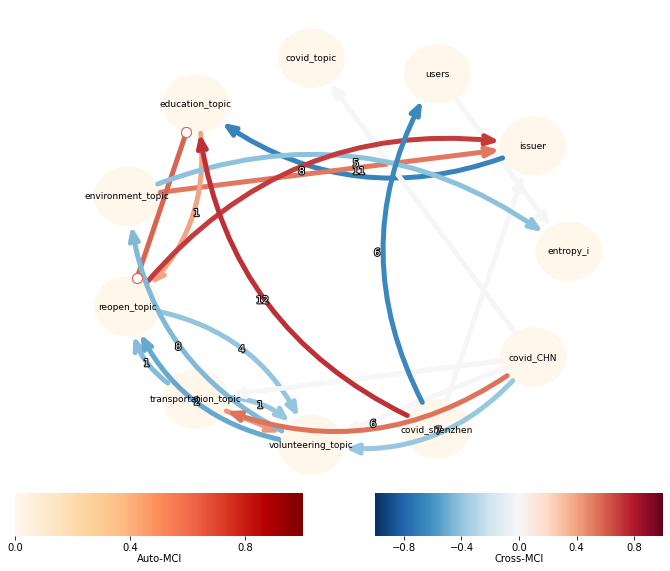

In [4]:
DAG_plot_for_all_diff(df_first_iss,independence_test ='parcorr', tau_max =14, NCE_type = 'issuer',alpha = 0.2, 
         file_name =None,delete_conflict_links=True,link_name = 'causal_result/o_nce_first_link', 
                      p_name = 'causal_result/o_nce_first_p')

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


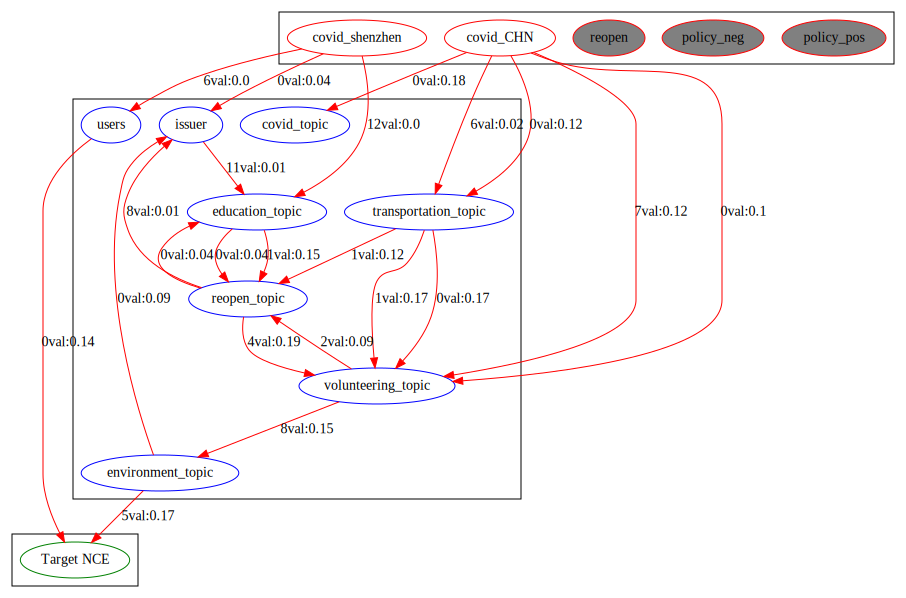

In [5]:
#Full causal graph for the first O-NCE regime
graphviz_plot2(df_first_iss,np.load('causal_result/o_nce_first_link.npy'),np.load('causal_result/o_nce_first_p.npy'), filename =None)

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(1, 0), (1, -1), (1, -2), (1, -3), (1, -4), (1, -5), (1, -6), (1, -7), (1, -8), (1, -9), (1, -10), (1, -11), (1, -12), (1, -13), (1, -14), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4), (2, -5), (2, -6), (2, -7), (2, -8), (2, -9), (2, -10), (2, -11), (2, -12), (2, -13), (2, -14), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4), (3, -5), (3, -6), (3, -7), (3, -8), (3, -9), (3, -10), (3, -11), (3, -12), (3, -13), (3, -14), (4, 0), (4, -1), (4, -2), (4, -3), (4, -4), (4, -5), (4, -6), (4, -7), (4, -8), (4, -9), (4, -10), (4, -11), (4, -12), (4, -13), (4, -14), (5, 0), (5, -1), (5, -2), (5, -3), (5, -4), (5, -5), (5, -6), (5, -7), (5, -8), (5, -9), (5, -10), (5, -11), (5, -12), (5, -13), (5, -14), (6, 0), (6, -1), (6, -2), (6, -3), (6, -4), (6, -5), (6, -6), (6, -7), (6, -8), (6, -9), (6, -10), (6, -11), (6, -12), (6, -13), (6, -14), (7, 0), (7, -1), (7, -2), (7, -3), (7, -4), (7, -5), (7, -6), (7, -7), (7, -

    Subset 0: () gives pval = 0.22430 / val =  0.159
    Non-significance detected.

    Link (covid_CHN -11) --> issuer (123/126):
    Subset 0: () gives pval = 0.85902 / val = -0.023
    Non-significance detected.

    Link (covid_CHN -12) --> issuer (124/126):
    Subset 0: () gives pval = 0.94395 / val = -0.009
    Non-significance detected.

    Link (covid_CHN -13) --> issuer (125/126):
    Subset 0: () gives pval = 0.07695 / val =  0.230
    Non-significance detected.

    Link (covid_CHN -14) --> issuer (126/126):
    Subset 0: () gives pval = 0.79051 / val = -0.035
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable issuer has 16 parent(s):
        (environment_topic -7): max_pval = 0.00124, min_val =  0.407
        (reopen_topic -11): max_pval = 0.00160, min_val =  0.399
        (covid_topic -7): max_pval = 0.00336, min_val =  0.373
        (issuer -1): max_pval

    Non-significance detected.

    Link (issuer -8) --> covid_topic (8/126):
    Subset 0: () gives pval = 0.18537 / val =  0.173
    Non-significance detected.

    Link (issuer -9) --> covid_topic (9/126):
    Subset 0: () gives pval = 0.01442 / val =  0.314
    No conditions of dimension 0 left.

    Link (issuer -10) --> covid_topic (10/126):
    Subset 0: () gives pval = 0.00065 / val =  0.428
    No conditions of dimension 0 left.

    Link (issuer -11) --> covid_topic (11/126):
    Subset 0: () gives pval = 0.01772 / val =  0.305
    No conditions of dimension 0 left.

    Link (issuer -12) --> covid_topic (12/126):
    Subset 0: () gives pval = 0.44065 / val =  0.101
    Non-significance detected.

    Link (issuer -13) --> covid_topic (13/126):
    Subset 0: () gives pval = 0.52515 / val =  0.084
    Non-significance detected.

    Link (issuer -14) --> covid_topic (14/126):
    Subset 0: () gives pval = 0.36964 / val =  0.118
    Non-significance detected.

    Link (users -

    Subset 0: () gives pval = 0.02478 / val =  0.290
    No conditions of dimension 0 left.

    Link (transportation_topic -6) --> education_topic (90/126):
    Subset 0: () gives pval = 0.12301 / val =  0.201
    Non-significance detected.

    Link (transportation_topic -7) --> education_topic (91/126):
    Subset 0: () gives pval = 0.00000 / val =  0.561
    No conditions of dimension 0 left.

    Link (transportation_topic -8) --> education_topic (92/126):
    Subset 0: () gives pval = 0.00052 / val =  0.435
    No conditions of dimension 0 left.

    Link (transportation_topic -9) --> education_topic (93/126):
    Subset 0: () gives pval = 0.00452 / val =  0.362
    No conditions of dimension 0 left.

    Link (transportation_topic -10) --> education_topic (94/126):
    Subset 0: () gives pval = 0.00560 / val =  0.353
    No conditions of dimension 0 left.

    Link (transportation_topic -11) --> education_topic (95/126):
    Subset 0: () gives pval = 0.00042 / val =  0.441
    N

    Subset 0: () gives pval = 0.19408 / val =  0.170
    Non-significance detected.

    Link (transportation_topic -4) --> environment_topic (88/126):
    Subset 0: () gives pval = 0.00549 / val =  0.354
    No conditions of dimension 0 left.

    Link (transportation_topic -5) --> environment_topic (89/126):
    Subset 0: () gives pval = 0.08226 / val =  0.226
    Non-significance detected.

    Link (transportation_topic -6) --> environment_topic (90/126):
    Subset 0: () gives pval = 0.71068 / val = -0.049
    Non-significance detected.

    Link (transportation_topic -7) --> environment_topic (91/126):
    Subset 0: () gives pval = 0.38276 / val =  0.115
    Non-significance detected.

    Link (transportation_topic -8) --> environment_topic (92/126):
    Subset 0: () gives pval = 0.03391 / val =  0.274
    No conditions of dimension 0 left.

    Link (transportation_topic -9) --> environment_topic (93/126):
    Subset 0: () gives pval = 0.06633 / val =  0.239
    Non-significanc


    Link (covid_topic -10) --> transportation_topic (38/126):
    Subset 0: () gives pval = 0.24938 / val =  0.151
    Non-significance detected.

    Link (covid_topic -11) --> transportation_topic (39/126):
    Subset 0: () gives pval = 0.02418 / val =  0.291
    No conditions of dimension 0 left.

    Link (covid_topic -12) --> transportation_topic (40/126):
    Subset 0: () gives pval = 0.01028 / val =  0.329
    No conditions of dimension 0 left.

    Link (covid_topic -13) --> transportation_topic (41/126):
    Subset 0: () gives pval = 0.05129 / val =  0.253
    Non-significance detected.

    Link (covid_topic -14) --> transportation_topic (42/126):
    Subset 0: () gives pval = 0.24214 / val =  0.153
    Non-significance detected.

    Link (education_topic -1) --> transportation_topic (43/126):
    Subset 0: () gives pval = 0.00024 / val =  0.458
    No conditions of dimension 0 left.

    Link (education_topic -2) --> transportation_topic (44/126):
    Subset 0: () gives pv

    Subset 0: () gives pval = 0.00040 / val =  0.442
    No conditions of dimension 0 left.

    Link (education_topic -8) --> volunteering_topic (50/126):
    Subset 0: () gives pval = 0.00040 / val =  0.442
    No conditions of dimension 0 left.

    Link (education_topic -9) --> volunteering_topic (51/126):
    Subset 0: () gives pval = 0.00560 / val =  0.353
    No conditions of dimension 0 left.

    Link (education_topic -10) --> volunteering_topic (52/126):
    Subset 0: () gives pval = 0.00670 / val =  0.346
    No conditions of dimension 0 left.

    Link (education_topic -11) --> volunteering_topic (53/126):
    Subset 0: () gives pval = 0.03688 / val =  0.270
    No conditions of dimension 0 left.

    Link (education_topic -12) --> volunteering_topic (54/126):
    Subset 0: () gives pval = 0.17096 / val =  0.179
    Non-significance detected.

    Link (education_topic -13) --> volunteering_topic (55/126):
    Subset 0: () gives pval = 0.02216 / val =  0.295
    No conditio

    Subset 0: () gives pval = 0.00676 / val =  0.368
    No conditions of dimension 0 left.

    Link (education_topic -1) --> volunteering_topic (42/99):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (covid_topic -12) (covid_CHN -13) (covid_CHN -2) ]
    with conds_x = [ (transportation_topic -15) (education_topic -8) (volunteering_topic -2) ]
    Subset 0: () gives pval = 0.00218 / val =  0.408
    No conditions of dimension 0 left.

    Link (environment_topic  0) o-o entropy_i (43/99):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (education_topic -14) (issuer -10) ]
    with conds_x = [ (volunteering_topic -11) ]
    Subset 0: () gives pval = 0.00216 / val = -0.398
    No conditions of dimension 0 left.

    Link (environment_topic  0) o-o issuer (44/99):
    Already removed.

    Link (environment_topic -7) --> issuer (45/99):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (reopen_topic -11) ]
    with conds_x = 

    Subset 3: (covid_topic 0)  gives pval = 0.01713 / val =  0.317
    Subset 4: (education_topic 0)  gives pval = 0.02578 / val =  0.298
    Subset 5: (users 0)  gives pval = 0.01738 / val =  0.317
    No conditions of dimension 1 left.

    Link (covid_CHN -13) --> volunteering_topic (59/59):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ (covid_topic -12) (education_topic -1) (covid_CHN -2) ]
    with conds_x = [ ]
    Subset 0: (transportation_topic 0)  gives pval = 0.30848 / val =  0.139
    Non-significance detected.

Updated contemp. adjacencies:

    Variable entropy_i has 2 parent(s):
        (covid_topic  0): max_pval = 0.04250, min_val =  0.272
        (users  0): max_pval = 0.04881, min_val =  0.272

    Variable issuer has 2 parent(s):
        (users  0): max_pval = 0.00025, min_val =  0.478
        (volunteering_topic  0): max_pval = 0.00850, min_val =  0.358

    Variable users has 2 parent(s):
        (issuer  0): max_pval = 0.00025, min_val =  0.4

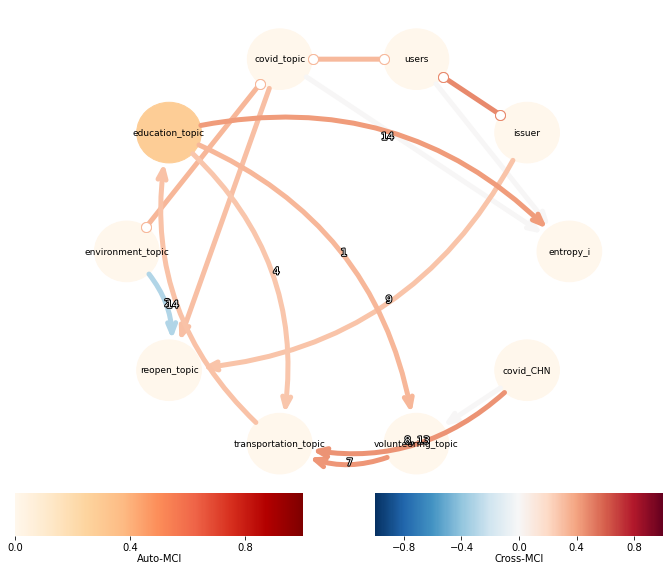

In [6]:
DAG_plot_for_all_diff(df_second_iss,independence_test ='parcorr', tau_max =14, NCE_type = 'issuer',alpha =0.05, 
         file_name =None, delete_conflict_links=True,link_name = 'causal_result/o_nce_second_link', p_name = 'causal_result/o_nce_second_p')

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


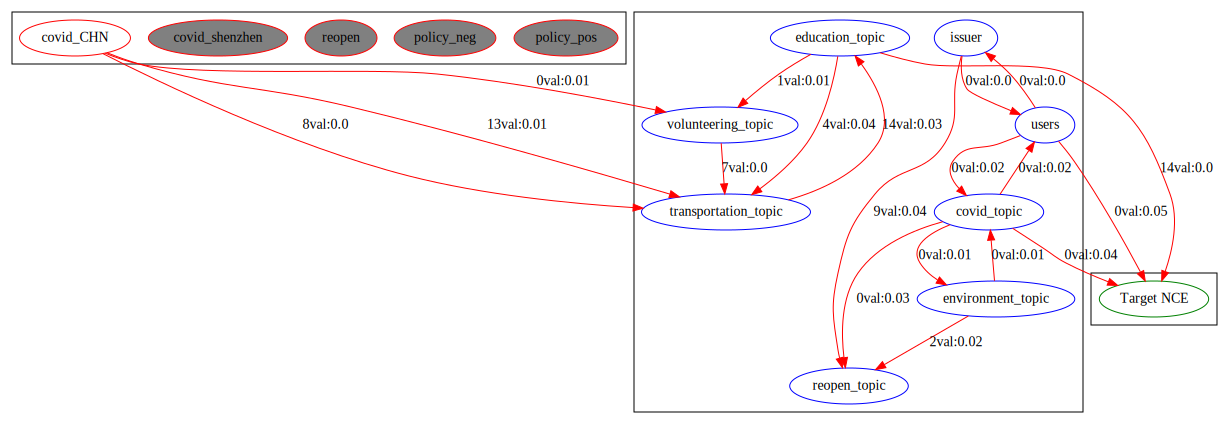

In [7]:
#Full causal graph for the second O-NCE regime
graphviz_plot2(df_second_iss,np.load('causal_result/o_nce_second_link.npy'),np.load('causal_result/o_nce_second_p.npy'), filename = None)

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(1, 0), (1, -1), (1, -2), (1, -3), (1, -4), (1, -5), (1, -6), (1, -7), (1, -8), (1, -9), (1, -10), (1, -11), (1, -12), (1, -13), (1, -14), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4), (2, -5), (2, -6), (2, -7), (2, -8), (2, -9), (2, -10), (2, -11), (2, -12), (2, -13), (2, -14), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4), (3, -5), (3, -6), (3, -7), (3, -8), (3, -9), (3, -10), (3, -11), (3, -12), (3, -13), (3, -14), (4, 0), (4, -1), (4, -2), (4, -3), (4, -4), (4, -5), (4, -6), (4, -7), (4, -8), (4, -9), (4, -10), (4, -11), (4, -12), (4, -13), (4, -14), (5, 0), (5, -1), (5, -2), (5, -3), (5, -4), (5, -5), (5, -6), (5, -7), (5, -8), (5, -9), (5, -10), (5, -11), (5, -12), (5, -13), (5, -14), (6, 0), (6, -1), (6, -2), (6, -3), (6, -4), (6, -5), (6, -6), (6, -7), (6, -8), (6, -9), (6, -10), (6, -11), (6, -12), (6, -13), (6, -14), (7, 0), (7, -1), (7, -2), (7, -3), (7, -4), (7, -5), (7, -6), (7, -7), (7, -

    Subset 0: (environment_topic -6) (policy_pos -2)  gives pval = 0.90936 / val =  0.035
    Non-significance detected.

    Link (transportation_topic -10) --> entropy_i (8/15):
    Subset 0: (environment_topic -6) (policy_pos -2)  gives pval = 0.38103 / val = -0.265
    Non-significance detected.

    Link (covid_CHN -11) --> entropy_i (9/15):
    Subset 0: (environment_topic -6) (policy_pos -2)  gives pval = 0.00447 / val = -0.732
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (policy_pos -4) --> entropy_i (10/15):
    Subset 0: (environment_topic -6) (policy_pos -2)  gives pval = 0.11366 / val =  0.460
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (reopen_topic -12) --> entropy_i (11/15):
    Subset 0: (environment_topic -6) (policy_pos -2)  gives pval = 0.02921 / val =  0.603
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (reopen_topic -2) --> entropy_i (12/15):
    Subset 0: (environment_topic -6) (polic

    Subset 0: (education_topic -1)  gives pval = 0.47550 / val = -0.208
    Non-significance detected.

    Link (policy_pos -2) --> issuer (37/77):
    Subset 0: (education_topic -1)  gives pval = 0.11636 / val = -0.439
    No conditions of dimension 1 left.

    Link (volunteering_topic -10) --> issuer (38/77):
    Subset 0: (education_topic -1)  gives pval = 0.65753 / val = -0.130
    Non-significance detected.

    Link (users -10) --> issuer (39/77):
    Subset 0: (education_topic -1)  gives pval = 0.45360 / val = -0.218
    Non-significance detected.

    Link (reopen_topic -1) --> issuer (40/77):
    Subset 0: (education_topic -1)  gives pval = 0.41917 / val =  0.235
    Non-significance detected.

    Link (environment_topic -2) --> issuer (41/77):
    Subset 0: (education_topic -1)  gives pval = 0.21862 / val =  0.351
    Non-significance detected.

    Link (users -11) --> issuer (42/77):
    Subset 0: (education_topic -1)  gives pval = 0.49499 / val = -0.199
    Non-signific

    Subset 0: (users -1)  gives pval = 0.52229 / val =  0.187
    Non-significance detected.

    Link (reopen_topic -6) --> users (31/82):
    Subset 0: (users -1)  gives pval = 0.48878 / val =  0.202
    Non-significance detected.

    Link (volunteering_topic -10) --> users (32/82):
    Subset 0: (users -1)  gives pval = 0.57266 / val = -0.165
    Non-significance detected.

    Link (environment_topic -3) --> users (33/82):
    Subset 0: (users -1)  gives pval = 0.91340 / val = -0.032
    Non-significance detected.

    Link (education_topic -11) --> users (34/82):
    Subset 0: (users -1)  gives pval = 0.53004 / val = -0.183
    Non-significance detected.

    Link (policy_pos -8) --> users (35/82):
    Subset 0: (users -1)  gives pval = 0.31705 / val =  0.289
    Non-significance detected.

    Link (covid_topic -14) --> users (36/82):
    Subset 0: (users -1)  gives pval = 0.01263 / val =  0.646
    No conditions of dimension 1 left.

    Link (covid_topic -6) --> users (37/82):

    Subset 0: (users -1)  gives pval = 0.80164 / val = -0.074
    Non-significance detected.

    Link (transportation_topic -8) --> covid_topic (24/77):
    Subset 0: (users -1)  gives pval = 0.30215 / val = -0.297
    Non-significance detected.

    Link (issuer -13) --> covid_topic (25/77):
    Subset 0: (users -1)  gives pval = 0.67732 / val = -0.122
    Non-significance detected.

    Link (transportation_topic -10) --> covid_topic (26/77):
    Subset 0: (users -1)  gives pval = 0.26593 / val = -0.319
    Non-significance detected.

    Link (education_topic -9) --> covid_topic (27/77):
    Subset 0: (users -1)  gives pval = 0.07827 / val = -0.486
    No conditions of dimension 1 left.

    Link (issuer -14) --> covid_topic (28/77):
    Subset 0: (users -1)  gives pval = 0.16984 / val =  0.388
    No conditions of dimension 1 left.

    Link (policy_pos -1) --> covid_topic (29/77):
    Subset 0: (users -1)  gives pval = 0.31889 / val =  0.288
    Non-significance detected.

    Li

    Subset 0: (education_topic -1)  gives pval = 0.02581 / val =  0.592
    No conditions of dimension 1 left.

    Link (environment_topic -1) --> education_topic (9/86):
    Subset 0: (education_topic -1)  gives pval = 0.08328 / val =  0.479
    No conditions of dimension 1 left.

    Link (issuer -10) --> education_topic (10/86):
    Subset 0: (education_topic -1)  gives pval = 0.02057 / val = -0.610
    No conditions of dimension 1 left.

    Link (issuer -13) --> education_topic (11/86):
    Subset 0: (education_topic -1)  gives pval = 0.43189 / val = -0.229
    Non-significance detected.

    Link (covid_topic -1) --> education_topic (12/86):
    Subset 0: (education_topic -1)  gives pval = 0.09100 / val =  0.469
    No conditions of dimension 1 left.

    Link (volunteering_topic -9) --> education_topic (13/86):
    Subset 0: (education_topic -1)  gives pval = 0.06198 / val = -0.511
    No conditions of dimension 1 left.

    Link (education_topic -1) --> education_topic (14/86)

    Subset 0: () gives pval = 0.24563 / val = -0.320
    Non-significance detected.

    Link (transportation_topic -13) --> environment_topic (97/140):
    Subset 0: () gives pval = 0.03003 / val = -0.560
    No conditions of dimension 0 left.

    Link (transportation_topic -14) --> environment_topic (98/140):
    Subset 0: () gives pval = 0.00067 / val = -0.776
    No conditions of dimension 0 left.

    Link (volunteering_topic -1) --> environment_topic (99/140):
    Subset 0: () gives pval = 0.01881 / val =  0.597
    No conditions of dimension 0 left.

    Link (volunteering_topic -2) --> environment_topic (100/140):
    Subset 0: () gives pval = 0.23855 / val =  0.324
    Non-significance detected.

    Link (volunteering_topic -3) --> environment_topic (101/140):
    Subset 0: () gives pval = 0.53437 / val =  0.174
    Non-significance detected.

    Link (volunteering_topic -4) --> environment_topic (102/140):
    Subset 0: () gives pval = 0.70560 / val = -0.107
    Non-signif

    Subset 0: () gives pval = 0.02671 / val =  0.569
    No conditions of dimension 0 left.

    Link (environment_topic -7) --> reopen_topic (63/140):
    Subset 0: () gives pval = 0.69959 / val =  0.109
    Non-significance detected.

    Link (environment_topic -8) --> reopen_topic (64/140):
    Subset 0: () gives pval = 0.13744 / val = -0.402
    No conditions of dimension 0 left.

    Link (environment_topic -9) --> reopen_topic (65/140):
    Subset 0: () gives pval = 0.20999 / val = -0.344
    Non-significance detected.

    Link (environment_topic -10) --> reopen_topic (66/140):
    Subset 0: () gives pval = 0.11669 / val = -0.422
    No conditions of dimension 0 left.

    Link (environment_topic -11) --> reopen_topic (67/140):
    Subset 0: () gives pval = 0.05694 / val = -0.501
    No conditions of dimension 0 left.

    Link (environment_topic -12) --> reopen_topic (68/140):
    Subset 0: () gives pval = 0.27772 / val = -0.300
    Non-significance detected.

    Link (enviro

    No conditions of dimension 0 left.

    Link (environment_topic -5) --> transportation_topic (61/140):
    Subset 0: () gives pval = 0.01239 / val =  0.627
    No conditions of dimension 0 left.

    Link (environment_topic -6) --> transportation_topic (62/140):
    Subset 0: () gives pval = 0.00167 / val =  0.738
    No conditions of dimension 0 left.

    Link (environment_topic -7) --> transportation_topic (63/140):
    Subset 0: () gives pval = 0.37481 / val =  0.247
    Non-significance detected.

    Link (environment_topic -8) --> transportation_topic (64/140):
    Subset 0: () gives pval = 0.61277 / val = -0.142
    Non-significance detected.

    Link (environment_topic -9) --> transportation_topic (65/140):
    Subset 0: () gives pval = 0.27221 / val = -0.303
    Non-significance detected.

    Link (environment_topic -10) --> transportation_topic (66/140):
    Subset 0: () gives pval = 0.21364 / val = -0.341
    Non-significance detected.

    Link (environment_topic -11

    Subset 0: () gives pval = 0.03630 / val = -0.543
    No conditions of dimension 0 left.

    Link (users -14) --> volunteering_topic (28/140):
    Subset 0: () gives pval = 0.00009 / val = -0.840
    No conditions of dimension 0 left.

    Link (covid_topic -1) --> volunteering_topic (29/140):
    Subset 0: () gives pval = 0.01218 / val =  0.628
    No conditions of dimension 0 left.

    Link (covid_topic -2) --> volunteering_topic (30/140):
    Subset 0: () gives pval = 0.01916 / val =  0.596
    No conditions of dimension 0 left.

    Link (covid_topic -3) --> volunteering_topic (31/140):
    Subset 0: () gives pval = 0.01656 / val =  0.606
    No conditions of dimension 0 left.

    Link (covid_topic -4) --> volunteering_topic (32/140):
    Subset 0: () gives pval = 0.02699 / val =  0.569
    No conditions of dimension 0 left.

    Link (covid_topic -5) --> volunteering_topic (33/140):
    Subset 0: () gives pval = 0.07029 / val =  0.480
    No conditions of dimension 0 left.



    Subset 0: (transportation_topic -1) (covid_topic -1) (policy_pos -3) (policy_pos -2)  gives pval = 0.03469 / val =  0.638
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (policy_pos -2) --> volunteering_topic (5/5):
    Subset 0: (transportation_topic -1) (covid_topic -1) (policy_pos -3) (policy_pos -1)  gives pval = 0.34416 / val = -0.316
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable volunteering_topic has 4 parent(s):
        (transportation_topic -1): max_pval = 0.03089, min_val =  0.596
        (covid_topic -14): max_pval = 0.09394, min_val =  0.529
        (policy_pos -3): max_pval = 0.09297, min_val =  0.466
        (policy_pos -11): max_pval = 0.17751, min_val =  0.417

Algorithm converged for variable volunteering_topic

## Variable policy_pos

Iterating through pc_alpha = [0.2]:

# pc_alpha = 0.2 (1/1):

Algorithm converged for v

    Subset 1: (education_topic 0)  gives pval = 0.87025 / val = -0.077
    Non-significance detected.

    Link (transportation_topic  0) o-o reopen_topic (44/66):
    Already removed.

    Link (transportation_topic  0) o-o volunteering_topic (45/66):
    Iterate through 5 subset(s) of conditions: 
    with conds_y = [ (transportation_topic -1) (covid_topic -14) (policy_pos -3) (policy_pos -11) ]
    with conds_x = [ (covid_topic -14) (policy_pos -2) (policy_pos -11) (policy_pos -3) ]
    Subset 0: (environment_topic 0)  gives pval = 0.06507 / val =  0.637
    Subset 1: (issuer 0)  gives pval = 0.02238 / val =  0.741
    Subset 2: (education_topic 0)  gives pval = 0.08387 / val =  0.606
    Subset 3: (users 0)  gives pval = 0.03815 / val =  0.694
    Subset 4: (reopen_topic 0)  gives pval = 0.16056 / val =  0.510
    No conditions of dimension 1 left.

    Link (volunteering_topic  0) o-o entropy_i (46/66):
    Iterate through 5 subset(s) of conditions: 
    with conds_y = [ (environm

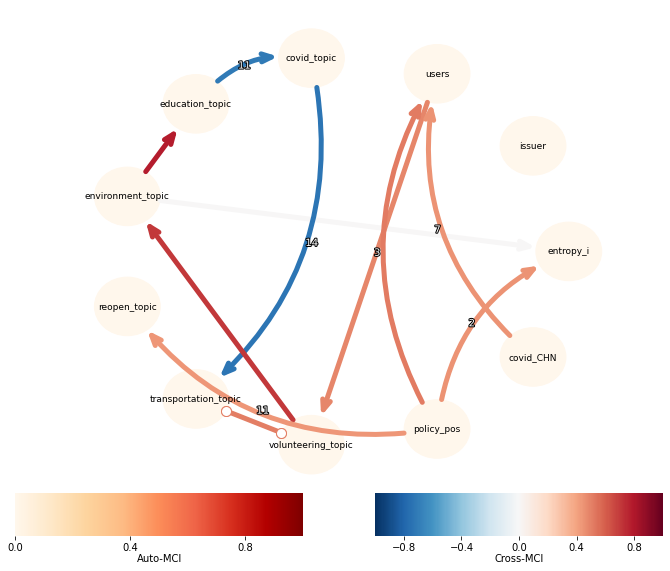

In [8]:
DAG_plot_for_all_diff(df_third_iss,independence_test ='parcorr', tau_max =14, NCE_type = 'issuer',alpha = 0.2, 
         file_name =None,link_name = 'causal_result/o_nce_third_link',p_name = 'causal_result/o_nce_third_p')

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


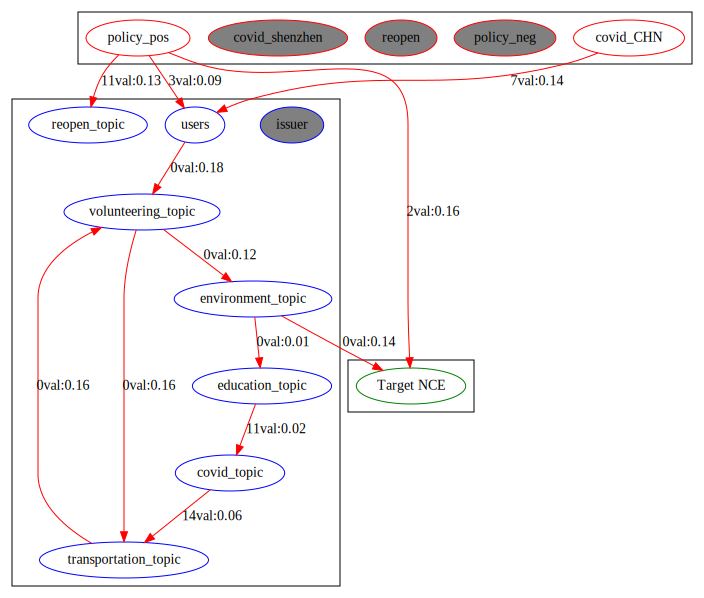

In [9]:
#Full causal graph for the third O-NCE regime
graphviz_plot2(df_third_iss,np.load('causal_result/o_nce_third_link.npy'),np.load('causal_result/o_nce_third_p.npy'), filename = None)

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(1, 0), (1, -1), (1, -2), (1, -3), (1, -4), (1, -5), (1, -6), (1, -7), (1, -8), (1, -9), (1, -10), (1, -11), (1, -12), (1, -13), (1, -14), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4), (2, -5), (2, -6), (2, -7), (2, -8), (2, -9), (2, -10), (2, -11), (2, -12), (2, -13), (2, -14), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4), (3, -5), (3, -6), (3, -7), (3, -8), (3, -9), (3, -10), (3, -11), (3, -12), (3, -13), (3, -14), (4, 0), (4, -1), (4, -2), (4, -3), (4, -4), (4, -5), (4, -6), (4, -7), (4, -8), (4, -9), (4, -10), (4, -11), (4, -12), (4, -13), (4, -14), (5, 0), (5, -1), (5, -2), (5, -3), (5, -4), (5, -5), (5, -6), (5, -7), (5, -8), (5, -9), (5, -10), (5, -11), (5, -12), (5, -13), (5, -14), (6, 0), (6, -1), (6, -2), (6, -3), (6, -4), (6, -5), (6, -6), (6, -7), (6, -8), (6, -9), (6, -10), (6, -11), (6, -12), (6, -13), (6, -14), (7, 0), (7, -1), (7, -2), (7, -3), (7, -4), (7, -5), (7, -6), (7, -7), (7, -

    Subset 0: () gives pval = 0.03581 / val =  0.269
    No conditions of dimension 0 left.

    Link (environment_topic -6) --> issuer (62/140):
    Subset 0: () gives pval = 0.01286 / val =  0.317
    No conditions of dimension 0 left.

    Link (environment_topic -7) --> issuer (63/140):
    Subset 0: () gives pval = 0.00117 / val =  0.406
    No conditions of dimension 0 left.

    Link (environment_topic -8) --> issuer (64/140):
    Subset 0: () gives pval = 0.04415 / val =  0.259
    No conditions of dimension 0 left.

    Link (environment_topic -9) --> issuer (65/140):
    Subset 0: () gives pval = 0.12691 / val =  0.198
    Non-significance detected.

    Link (environment_topic -10) --> issuer (66/140):
    Subset 0: () gives pval = 0.41079 / val =  0.107
    Non-significance detected.

    Link (environment_topic -11) --> issuer (67/140):
    Subset 0: () gives pval = 0.05140 / val =  0.251
    No conditions of dimension 0 left.

    Link (environment_topic -12) --> issuer (

    Subset 0: () gives pval = 0.00112 / val =  0.407
    No conditions of dimension 0 left.

    Link (issuer -6) --> users (6/140):
    Subset 0: () gives pval = 0.01502 / val =  0.310
    No conditions of dimension 0 left.

    Link (issuer -7) --> users (7/140):
    Subset 0: () gives pval = 0.05218 / val =  0.250
    No conditions of dimension 0 left.

    Link (issuer -8) --> users (8/140):
    Subset 0: () gives pval = 0.13107 / val =  0.195
    Non-significance detected.

    Link (issuer -9) --> users (9/140):
    Subset 0: () gives pval = 0.27330 / val =  0.142
    Non-significance detected.

    Link (issuer -10) --> users (10/140):
    Subset 0: () gives pval = 0.45224 / val =  0.098
    Non-significance detected.

    Link (issuer -11) --> users (11/140):
    Subset 0: () gives pval = 0.27553 / val =  0.142
    Non-significance detected.

    Link (issuer -12) --> users (12/140):
    Subset 0: () gives pval = 0.45312 / val =  0.098
    Non-significance detected.

    Link (

    Subset 0: () gives pval = 0.80386 / val = -0.032
    Non-significance detected.

    Link (education_topic -1) --> covid_topic (43/140):
    Subset 0: () gives pval = 0.00001 / val =  0.532
    No conditions of dimension 0 left.

    Link (education_topic -2) --> covid_topic (44/140):
    Subset 0: () gives pval = 0.00043 / val =  0.437
    No conditions of dimension 0 left.

    Link (education_topic -3) --> covid_topic (45/140):
    Subset 0: () gives pval = 0.00018 / val =  0.461
    No conditions of dimension 0 left.

    Link (education_topic -4) --> covid_topic (46/140):
    Subset 0: () gives pval = 0.00161 / val =  0.395
    No conditions of dimension 0 left.

    Link (education_topic -5) --> covid_topic (47/140):
    Subset 0: () gives pval = 0.00001 / val =  0.530
    No conditions of dimension 0 left.

    Link (education_topic -6) --> covid_topic (48/140):
    Subset 0: () gives pval = 0.00000 / val =  0.604
    No conditions of dimension 0 left.

    Link (education_t

    Subset 0: (issuer -5) (issuer -7)  gives pval = 0.07920 / val =  0.230
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (education_topic -3) --> covid_topic (35/35):
    Subset 0: (issuer -5) (issuer -7)  gives pval = 0.82402 / val =  0.030
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable covid_topic has 24 parent(s):

Testing condition sets of dimension 3:

    Link (issuer -7) --> covid_topic (1/24):
    Subset 0: (transportation_topic -6) (issuer -5) (volunteering_topic -6)  gives pval = 0.00103 / val =  0.420
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (transportation_topic -6) --> covid_topic (2/24):
    Subset 0: (issuer -7) (issuer -5) (volunteering_topic -6)  gives pval = 0.03945 / val =  0.271
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (issuer -5) --> covid_topic (3/24):
    Su

    Subset 0: (environment_topic -1)  gives pval = 0.10627 / val =  0.211
    Non-significance detected.

    Link (environment_topic -3) --> education_topic (51/77):
    Subset 0: (environment_topic -1)  gives pval = 0.96942 / val =  0.005
    Non-significance detected.

    Link (transportation_topic -11) --> education_topic (52/77):
    Subset 0: (environment_topic -1)  gives pval = 0.54422 / val =  0.080
    Non-significance detected.

    Link (issuer -12) --> education_topic (53/77):
    Subset 0: (environment_topic -1)  gives pval = 0.99063 / val = -0.002
    Non-significance detected.

    Link (education_topic -3) --> education_topic (54/77):
    Subset 0: (environment_topic -1)  gives pval = 0.24193 / val =  0.153
    Non-significance detected.

    Link (environment_topic -11) --> education_topic (55/77):
    Subset 0: (environment_topic -1)  gives pval = 0.18324 / val =  0.174
    Non-significance detected.

    Link (transportation_topic -12) --> education_topic (56/77):
 

    Subset 0: (environment_topic -1)  gives pval = 0.08146 / val =  0.227
    No conditions of dimension 1 left.

    Link (issuer -12) --> environment_topic (44/90):
    Subset 0: (environment_topic -1)  gives pval = 0.53231 / val =  0.082
    Non-significance detected.

    Link (transportation_topic -11) --> environment_topic (45/90):
    Subset 0: (environment_topic -1)  gives pval = 0.20233 / val =  0.167
    Non-significance detected.

    Link (users -9) --> environment_topic (46/90):
    Subset 0: (environment_topic -1)  gives pval = 0.26158 / val =  0.147
    Non-significance detected.

    Link (covid_topic -7) --> environment_topic (47/90):
    Subset 0: (environment_topic -1)  gives pval = 0.93977 / val =  0.010
    Non-significance detected.

    Link (environment_topic -7) --> environment_topic (48/90):
    Subset 0: (environment_topic -1)  gives pval = 0.70158 / val =  0.050
    Non-significance detected.

    Link (users -13) --> environment_topic (49/90):
    Subset 0:

    Subset 0: () gives pval = 0.68546 / val =  0.053
    Non-significance detected.

    Link (covid_shenzhen -10) --> reopen_topic (122/140):
    Subset 0: () gives pval = 0.83960 / val =  0.026
    Non-significance detected.

    Link (covid_shenzhen -11) --> reopen_topic (123/140):
    Subset 0: () gives pval = 0.76138 / val = -0.040
    Non-significance detected.

    Link (covid_shenzhen -12) --> reopen_topic (124/140):
    Subset 0: () gives pval = 0.37894 / val =  0.115
    Non-significance detected.

    Link (covid_shenzhen -13) --> reopen_topic (125/140):
    Subset 0: () gives pval = 0.57839 / val = -0.073
    Non-significance detected.

    Link (covid_shenzhen -14) --> reopen_topic (126/140):
    Subset 0: () gives pval = 0.38907 / val = -0.112
    Non-significance detected.

    Link (covid_CHN -1) --> reopen_topic (127/140):
    Subset 0: () gives pval = 0.11587 / val =  0.203
    Non-significance detected.

    Link (covid_CHN -2) --> reopen_topic (128/140):
    Subset 

    Subset 0: (covid_topic -1)  gives pval = 0.46810 / val =  0.095
    Non-significance detected.

    Link (covid_topic -6) --> transportation_topic (36/86):
    Subset 0: (covid_topic -1)  gives pval = 0.45816 / val =  0.098
    Non-significance detected.

    Link (covid_topic -5) --> transportation_topic (37/86):
    Subset 0: (covid_topic -1)  gives pval = 0.49287 / val =  0.090
    Non-significance detected.

    Link (issuer -1) --> transportation_topic (38/86):
    Subset 0: (covid_topic -1)  gives pval = 0.12674 / val =  0.199
    Non-significance detected.

    Link (issuer -12) --> transportation_topic (39/86):
    Subset 0: (covid_topic -1)  gives pval = 0.19403 / val =  0.170
    Non-significance detected.

    Link (volunteering_topic -5) --> transportation_topic (40/86):
    Subset 0: (covid_topic -1)  gives pval = 0.11062 / val =  0.208
    Non-significance detected.

    Link (users -8) --> transportation_topic (41/86):
    Subset 0: (covid_topic -1)  gives pval = 0.4

    Subset 0: () gives pval = 0.86788 / val = -0.022
    Non-significance detected.

    Link (covid_shenzhen -7) --> volunteering_topic (119/140):
    Subset 0: () gives pval = 0.45314 / val =  0.098
    Non-significance detected.

    Link (covid_shenzhen -8) --> volunteering_topic (120/140):
    Subset 0: () gives pval = 0.41609 / val = -0.106
    Non-significance detected.

    Link (covid_shenzhen -9) --> volunteering_topic (121/140):
    Subset 0: () gives pval = 0.80206 / val = -0.033
    Non-significance detected.

    Link (covid_shenzhen -10) --> volunteering_topic (122/140):
    Subset 0: () gives pval = 0.51299 / val =  0.085
    Non-significance detected.

    Link (covid_shenzhen -11) --> volunteering_topic (123/140):
    Subset 0: () gives pval = 0.58154 / val =  0.072
    Non-significance detected.

    Link (covid_shenzhen -12) --> volunteering_topic (124/140):
    Subset 0: () gives pval = 0.84691 / val = -0.025
    Non-significance detected.

    Link (covid_shenzhen

    Subset 0: () gives pval = 0.09252 / val =  0.233
    No conditions of dimension 0 left.

    Link (covid_topic  0) o-o volunteering_topic (38/113):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (volunteering_topic -1) (volunteering_topic -6) (transportation_topic -4) ]
    with conds_x = [ (issuer -7) (issuer -5) (users -11) (covid_topic -1) ]
    Subset 0: () gives pval = 0.00000 / val =  0.729
    No conditions of dimension 0 left.

    Link (education_topic  0) o-o entropy_i (39/113):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (covid_CHN -1) (users -2) (reopen_topic -4) ]
    with conds_x = [ (environment_topic -1) (volunteering_topic -6) (reopen_topic -14) (reopen_topic -10) ]
    Subset 0: () gives pval = 0.34023 / val = -0.132
    Non-significance detected.

    Link (education_topic  0) o-o issuer (40/113):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (users -1) (education_topic -7) (reopen_topic -14) (

    Iterate through 5 subset(s) of conditions: 
    with conds_y = [ (users -1) ]
    with conds_x = [ (environment_topic -1) (reopen_topic -14) (transportation_topic -4) (reopen_topic -10) ]
    Subset 0: (issuer 0)  gives pval = 0.00524 / val =  0.371
    Subset 1: (volunteering_topic 0)  gives pval = 0.03631 / val =  0.283
    Subset 2: (education_topic 0)  gives pval = 0.03493 / val =  0.285
    Subset 3: (transportation_topic 0)  gives pval = 0.04379 / val =  0.273
    Subset 4: (covid_topic 0)  gives pval = 0.00745 / val =  0.357
    No conditions of dimension 1 left.

    Link (environment_topic  0) o-o covid_topic (39/66):
    Already removed.

    Link (environment_topic  0) o-o education_topic (40/66):
    Iterate through 5 subset(s) of conditions: 
    with conds_y = [ (environment_topic -1) (volunteering_topic -6) (reopen_topic -14) (reopen_topic -10) ]
    with conds_x = [ (environment_topic -1) (reopen_topic -14) (transportation_topic -4) (reopen_topic -10) ]
    Subset 0

    Subset 5: (transportation_topic 0)  gives pval = 0.37379 / val =  0.126
    Fraction of separating subsets containing (volunteering_topic 0) is > 0.5 --> non-collider found

    Triple (volunteering_topic -1) --> volunteering_topic o-o education_topic (11/18)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (environment_topic -1) (volunteering_topic -6) (reopen_topic -14) (reopen_topic -10) ]
    with conds_x = [ (volunteering_topic -2) (volunteering_topic -7) (transportation_topic -5) ]
    Subset 0: (environment_topic 0) (volunteering_topic 0)  gives pval = 0.58290 / val = -0.078
    Subset 1: () gives pval = 0.04858 / val =  0.270
    Subset 2: (volunteering_topic 0)  gives pval = 0.64561 / val = -0.065
    Subset 3: (environment_topic 0)  gives pval = 0.53276 / val =  0.088
    Fraction of separating subsets containing (volunteering_topic 0) is > 0.5 --> non-collider found

    Triple (volunteering_topic -6) --> volunteering_topic o-o education_topi

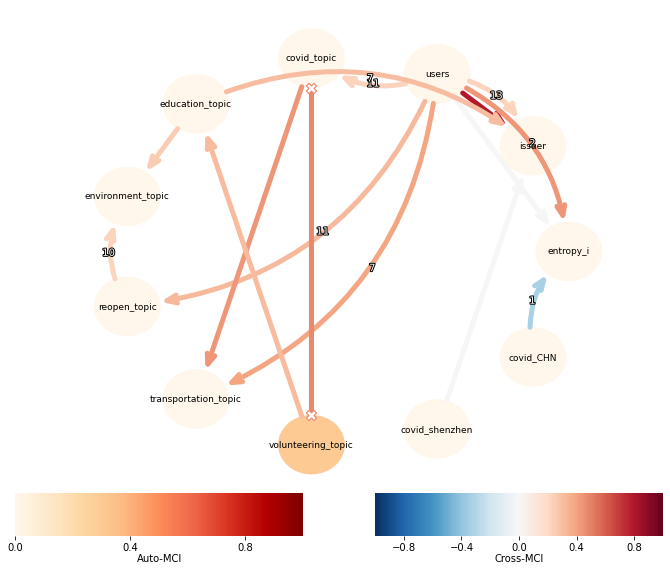

In [10]:
DAG_plot_for_all_diff(df_fourth_iss,independence_test ='parcorr', tau_max =14, NCE_type = 'issuer',alpha =0.1,
         file_name =None,link_name = 'causal_result/o_nce_fourth_link', p_name = 'causal_result/o_nce_fourth_p')

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


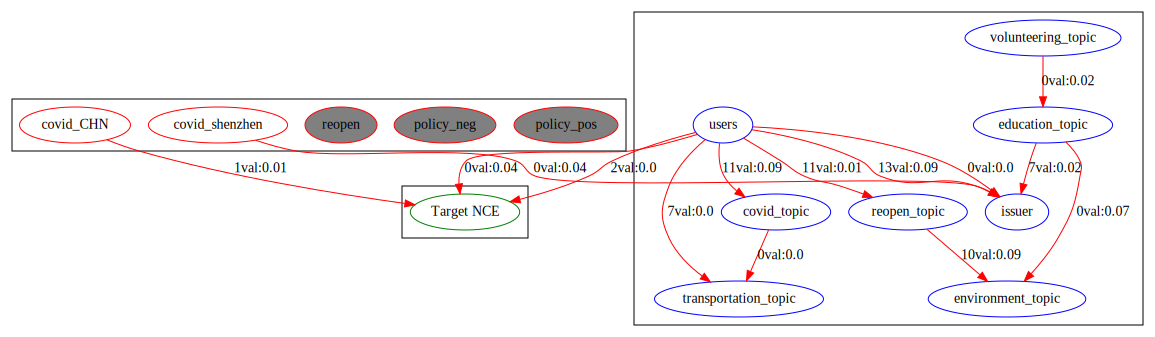

In [11]:
#Full causal graph for the fourth O-NCE regime
graphviz_plot2(df_fourth_iss,np.load('causal_result/o_nce_fourth_link.npy'),np.load('causal_result/o_nce_fourth_p.npy'), filename = None)

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(1, 0), (1, -1), (1, -2), (1, -3), (1, -4), (1, -5), (1, -6), (1, -7), (1, -8), (1, -9), (1, -10), (1, -11), (1, -12), (1, -13), (1, -14), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4), (2, -5), (2, -6), (2, -7), (2, -8), (2, -9), (2, -10), (2, -11), (2, -12), (2, -13), (2, -14), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4), (3, -5), (3, -6), (3, -7), (3, -8), (3, -9), (3, -10), (3, -11), (3, -12), (3, -13), (3, -14), (4, 0), (4, -1), (4, -2), (4, -3), (4, -4), (4, -5), (4, -6), (4, -7), (4, -8), (4, -9), (4, -10), (4, -11), (4, -12), (4, -13), (4, -14), (5, 0), (5, -1), (5, -2), (5, -3), (5, -4), (5, -5), (5, -6), (5, -7), (5, -8), (5, -9), (5, -10), (5, -11), (5, -12), (5, -13), (5, -14), (6, 0), (6, -1), (6, -2), (6, -3), (6, -4), (6, -5), (6, -6), (6, -7), (6, -8), (6, -9), (6, -10), (6, -11), (6, -12), (6, -13), (6, -14), (7, 0), (7, -1), (7, -2), (7, -3), (7, -4), (7, -5), (7, -6), (7, -7), (7, -

    Subset 0: () gives pval = 0.81325 / val = -0.031
    Non-significance detected.

    Link (reopen_topic -8) --> issuer (78/126):
    Subset 0: () gives pval = 0.19004 / val =  0.170
    Non-significance detected.

    Link (reopen_topic -9) --> issuer (79/126):
    Subset 0: () gives pval = 0.31600 / val =  0.131
    Non-significance detected.

    Link (reopen_topic -10) --> issuer (80/126):
    Subset 0: () gives pval = 0.54019 / val = -0.080
    Non-significance detected.

    Link (reopen_topic -11) --> issuer (81/126):
    Subset 0: () gives pval = 0.61958 / val = -0.065
    Non-significance detected.

    Link (reopen_topic -12) --> issuer (82/126):
    Subset 0: () gives pval = 0.71924 / val = -0.047
    Non-significance detected.

    Link (reopen_topic -13) --> issuer (83/126):
    Subset 0: () gives pval = 0.77568 / val = -0.037
    Non-significance detected.

    Link (reopen_topic -14) --> issuer (84/126):
    Subset 0: () gives pval = 0.79442 / val =  0.034
    Non-sig

    Subset 0: () gives pval = 0.71133 / val = -0.048
    Non-significance detected.

    Link (issuer -8) --> covid_topic (8/126):
    Subset 0: () gives pval = 0.63059 / val = -0.063
    Non-significance detected.

    Link (issuer -9) --> covid_topic (9/126):
    Subset 0: () gives pval = 0.64708 / val =  0.060
    Non-significance detected.

    Link (issuer -10) --> covid_topic (10/126):
    Subset 0: () gives pval = 0.15620 / val =  0.184
    Non-significance detected.

    Link (issuer -11) --> covid_topic (11/126):
    Subset 0: () gives pval = 0.31962 / val =  0.130
    Non-significance detected.

    Link (issuer -12) --> covid_topic (12/126):
    Subset 0: () gives pval = 0.36022 / val = -0.119
    Non-significance detected.

    Link (issuer -13) --> covid_topic (13/126):
    Subset 0: () gives pval = 0.12020 / val = -0.201
    Non-significance detected.

    Link (issuer -14) --> covid_topic (14/126):
    Subset 0: () gives pval = 0.11446 / val = -0.204
    Non-significance

    Subset 0: () gives pval = 0.86620 / val =  0.022
    Non-significance detected.

    Link (transportation_topic -6) --> education_topic (90/126):
    Subset 0: () gives pval = 0.64119 / val = -0.061
    Non-significance detected.

    Link (transportation_topic -7) --> education_topic (91/126):
    Subset 0: () gives pval = 0.11035 / val =  0.206
    Non-significance detected.

    Link (transportation_topic -8) --> education_topic (92/126):
    Subset 0: () gives pval = 0.66457 / val =  0.057
    Non-significance detected.

    Link (transportation_topic -9) --> education_topic (93/126):
    Subset 0: () gives pval = 0.94884 / val =  0.008
    Non-significance detected.

    Link (transportation_topic -10) --> education_topic (94/126):
    Subset 0: () gives pval = 0.74135 / val = -0.043
    Non-significance detected.

    Link (transportation_topic -11) --> education_topic (95/126):
    Subset 0: () gives pval = 0.93448 / val =  0.011
    Non-significance detected.

    Link (tra

    Subset 0: () gives pval = 0.94434 / val = -0.009
    Non-significance detected.

    Link (covid_topic -9) --> reopen_topic (37/126):
    Subset 0: () gives pval = 0.80015 / val = -0.033
    Non-significance detected.

    Link (covid_topic -10) --> reopen_topic (38/126):
    Subset 0: () gives pval = 0.54742 / val = -0.079
    Non-significance detected.

    Link (covid_topic -11) --> reopen_topic (39/126):
    Subset 0: () gives pval = 0.65589 / val =  0.058
    Non-significance detected.

    Link (covid_topic -12) --> reopen_topic (40/126):
    Subset 0: () gives pval = 0.46970 / val = -0.094
    Non-significance detected.

    Link (covid_topic -13) --> reopen_topic (41/126):
    Subset 0: () gives pval = 0.00204 / val = -0.387
    No conditions of dimension 0 left.

    Link (covid_topic -14) --> reopen_topic (42/126):
    Subset 0: () gives pval = 0.01230 / val = -0.319
    No conditions of dimension 0 left.

    Link (education_topic -1) --> reopen_topic (43/126):
    Subse

    Subset 0: (users -4)  gives pval = 0.00502 / val =  0.358
    No conditions of dimension 1 left.

    Link (education_topic -1) --> transportation_topic (3/20):
    Subset 0: (users -4)  gives pval = 0.00749 / val =  0.342
    No conditions of dimension 1 left.

    Link (environment_topic -4) --> transportation_topic (4/20):
    Subset 0: (users -4)  gives pval = 0.10505 / val =  0.211
    Non-significance detected.

    Link (users -3) --> transportation_topic (5/20):
    Subset 0: (users -4)  gives pval = 0.05078 / val =  0.253
    Non-significance detected.

    Link (transportation_topic -14) --> transportation_topic (6/20):
    Subset 0: (users -4)  gives pval = 0.04090 / val = -0.265
    No conditions of dimension 1 left.

    Link (education_topic -2) --> transportation_topic (7/20):
    Subset 0: (users -4)  gives pval = 0.07866 / val =  0.229
    Non-significance detected.

    Link (education_topic -4) --> transportation_topic (8/20):
    Subset 0: (users -4)  gives pval

    Subset 0: (volunteering_topic -1) (users -3) (education_topic -8) (education_topic -7)  gives pval = 0.00035 / val =  0.457
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (education_topic -7) --> volunteering_topic (5/9):
    Subset 0: (volunteering_topic -1) (users -3) (education_topic -8) (volunteering_topic -1)  gives pval = 0.25788 / val =  0.152
    Non-significance detected.

    Link (covid_CHN -2) --> volunteering_topic (6/9):
    Subset 0: (volunteering_topic -1) (users -3) (education_topic -8) (volunteering_topic -1)  gives pval = 0.00370 / val =  0.378
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (education_topic -1) --> volunteering_topic (7/9):
    Subset 0: (volunteering_topic -1) (users -3) (education_topic -8) (volunteering_topic -1)  gives pval = 0.02464 / val =  0.297
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (covid_CHN -13) --> volunteering_topic (8/9):
    Subset 0: (volunteering_t

    Subset 2: (education_topic 0)  gives pval = 0.00002 / val = -0.533
    No conditions of dimension 1 left.

    Link (reopen_topic  0) o-o entropy_p (36/53):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ (environment_topic -4) (covid_topic -14) (users -3) ]
    with conds_x = [ (reopen_topic -14) ]
    Subset 0: (users 0)  gives pval = 0.00069 / val = -0.440
    Subset 1: (issuer 0)  gives pval = 0.00475 / val = -0.372
    Subset 2: (education_topic 0)  gives pval = 0.02086 / val = -0.308
    Subset 3: (covid_topic 0)  gives pval = 0.14036 / val = -0.200
    Non-significance detected.

    Link (reopen_topic  0) o-o covid_topic (37/53):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (covid_topic -14) (environment_topic -2) (covid_topic -1) (covid_topic -6) ]
    with conds_x = [ (reopen_topic -14) ]
    Subset 0: (users 0)  gives pval = 0.05459 / val =  0.261
    Non-significance detected.

    Link (reopen_topic -14) --> reopen_topic (38

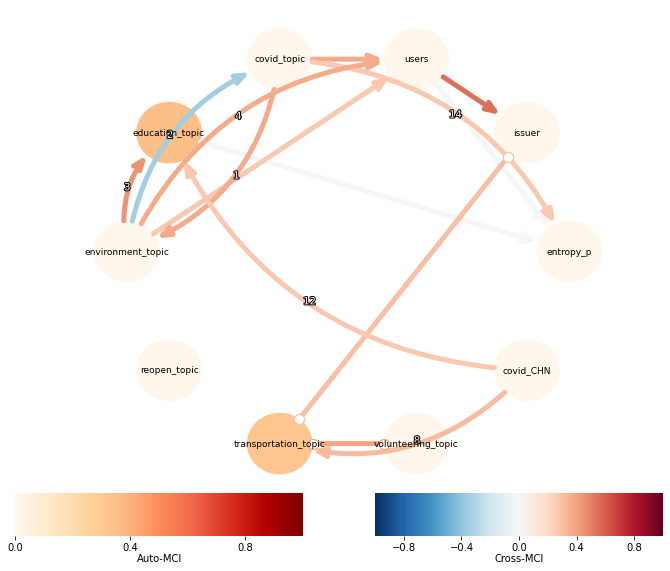

In [12]:
DAG_plot_for_all_diff(df_first_par,independence_test ='parcorr', tau_max =14, NCE_type = 'participate',alpha =0.05, 
         file_name =None,delete_conflict_links=True,link_name = 'causal_result/p_nce_first_link',p_name = 'causal_result/p_nce_first_p')

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


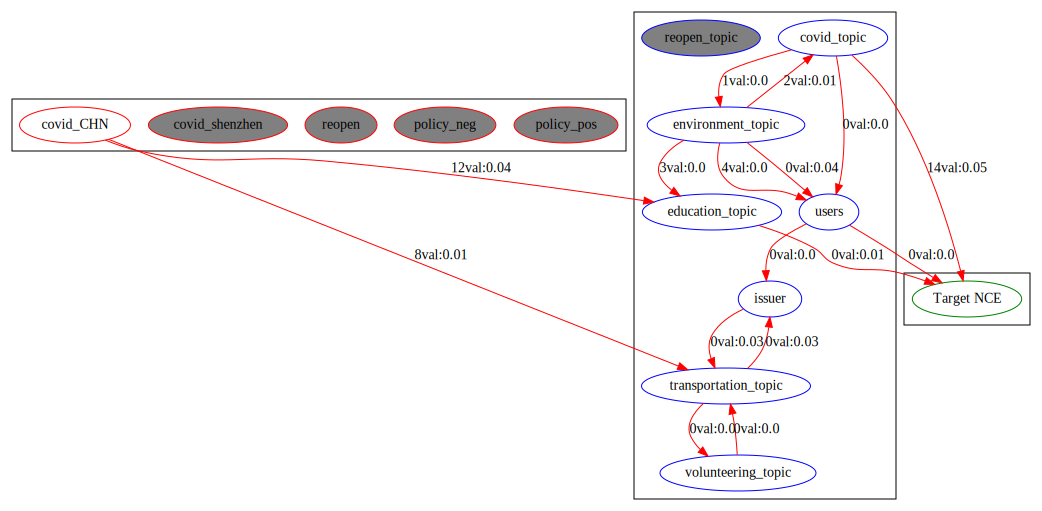

In [13]:
#Full causal graph for the first P-NCE regime
graphviz_plot2(df_first_par,np.load('causal_result/p_nce_first_link.npy'),np.load('causal_result/p_nce_first_p.npy'), filename = None)

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(1, 0), (1, -1), (1, -2), (1, -3), (1, -4), (1, -5), (1, -6), (1, -7), (1, -8), (1, -9), (1, -10), (1, -11), (1, -12), (1, -13), (1, -14), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4), (2, -5), (2, -6), (2, -7), (2, -8), (2, -9), (2, -10), (2, -11), (2, -12), (2, -13), (2, -14), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4), (3, -5), (3, -6), (3, -7), (3, -8), (3, -9), (3, -10), (3, -11), (3, -12), (3, -13), (3, -14), (4, 0), (4, -1), (4, -2), (4, -3), (4, -4), (4, -5), (4, -6), (4, -7), (4, -8), (4, -9), (4, -10), (4, -11), (4, -12), (4, -13), (4, -14), (5, 0), (5, -1), (5, -2), (5, -3), (5, -4), (5, -5), (5, -6), (5, -7), (5, -8), (5, -9), (5, -10), (5, -11), (5, -12), (5, -13), (5, -14), (6, 0), (6, -1), (6, -2), (6, -3), (6, -4), (6, -5), (6, -6), (6, -7), (6, -8), (6, -9), (6, -10), (6, -11), (6, -12), (6, -13), (6, -14), (7, 0), (7, -1), (7, -2), (7, -3), (7, -4), (7, -5), (7, -6), (7, -7), (7, -

    Subset 0: (users -1)  gives pval = 0.59464 / val =  0.071
    Non-significance detected.

    Link (issuer -5) --> entropy_p (60/74):
    Subset 0: (users -1)  gives pval = 0.49078 / val = -0.091
    Non-significance detected.

    Link (environment_topic -3) --> entropy_p (61/74):
    Subset 0: (users -1)  gives pval = 0.16439 / val = -0.183
    Non-significance detected.

    Link (issuer -12) --> entropy_p (62/74):
    Subset 0: (users -1)  gives pval = 0.20382 / val =  0.168
    Non-significance detected.

    Link (policy_pos -6) --> entropy_p (63/74):
    Subset 0: (users -1)  gives pval = 0.55220 / val = -0.079
    Non-significance detected.

    Link (issuer -6) --> entropy_p (64/74):
    Subset 0: (users -1)  gives pval = 0.61649 / val = -0.067
    Non-significance detected.

    Link (policy_pos -5) --> entropy_p (65/74):
    Subset 0: (users -1)  gives pval = 0.10555 / val = -0.213
    Non-significance detected.

    Link (transportation_topic -13) --> entropy_p (66/74):

    Subset 0: (users -1)  gives pval = 0.15247 / val =  0.189
    Non-significance detected.

    Link (volunteering_topic -2) --> issuer (25/73):
    Subset 0: (users -1)  gives pval = 0.38392 / val =  0.115
    Non-significance detected.

    Link (issuer -5) --> issuer (26/73):
    Subset 0: (users -1)  gives pval = 0.04631 / val =  0.260
    No conditions of dimension 1 left.

    Link (policy_pos -12) --> issuer (27/73):
    Subset 0: (users -1)  gives pval = 0.43428 / val =  0.104
    Non-significance detected.

    Link (reopen_topic -7) --> issuer (28/73):
    Subset 0: (users -1)  gives pval = 0.58062 / val =  0.073
    Non-significance detected.

    Link (education_topic -14) --> issuer (29/73):
    Subset 0: (users -1)  gives pval = 0.13302 / val = -0.198
    Non-significance detected.

    Link (users -5) --> issuer (30/73):
    Subset 0: (users -1)  gives pval = 0.08394 / val =  0.227
    No conditions of dimension 1 left.

    Link (environment_topic -7) --> issuer (31/7

    Subset 0: (users -1)  gives pval = 0.52814 / val =  0.084
    Non-significance detected.

    Link (education_topic -14) --> users (4/64):
    Subset 0: (users -1)  gives pval = 0.00286 / val = -0.382
    No conditions of dimension 1 left.

    Link (volunteering_topic -1) --> users (5/64):
    Subset 0: (users -1)  gives pval = 0.72669 / val =  0.046
    Non-significance detected.

    Link (volunteering_topic -14) --> users (6/64):
    Subset 0: (users -1)  gives pval = 0.01838 / val = -0.306
    No conditions of dimension 1 left.

    Link (users -2) --> users (7/64):
    Subset 0: (users -1)  gives pval = 0.79722 / val =  0.034
    Non-significance detected.

    Link (education_topic -5) --> users (8/64):
    Subset 0: (users -1)  gives pval = 0.09916 / val =  0.217
    No conditions of dimension 1 left.

    Link (environment_topic -6) --> users (9/64):
    Subset 0: (users -1)  gives pval = 0.06567 / val =  0.241
    No conditions of dimension 1 left.

    Link (issuer -2) -

    Subset 0: () gives pval = 0.51596 / val =  0.086
    Non-significance detected.

    Link (covid_CHN -3) --> covid_topic (143/154):
    Subset 0: () gives pval = 0.58233 / val = -0.072
    Non-significance detected.

    Link (covid_CHN -4) --> covid_topic (144/154):
    Subset 0: () gives pval = 0.43530 / val = -0.103
    Non-significance detected.

    Link (covid_CHN -5) --> covid_topic (145/154):
    Subset 0: () gives pval = 0.81273 / val =  0.031
    Non-significance detected.

    Link (covid_CHN -6) --> covid_topic (146/154):
    Subset 0: () gives pval = 0.61949 / val = -0.065
    Non-significance detected.

    Link (covid_CHN -7) --> covid_topic (147/154):
    Subset 0: () gives pval = 0.56230 / val =  0.076
    Non-significance detected.

    Link (covid_CHN -8) --> covid_topic (148/154):
    Subset 0: () gives pval = 0.14758 / val = -0.189
    Non-significance detected.

    Link (covid_CHN -9) --> covid_topic (149/154):
    Subset 0: () gives pval = 0.97011 / val = -0

    Subset 0: () gives pval = 0.11766 / val =  0.204
    Non-significance detected.

    Link (policy_pos -14) --> education_topic (126/154):
    Subset 0: () gives pval = 0.18959 / val =  0.172
    Non-significance detected.

    Link (policy_neg -1) --> education_topic (127/154):
    Subset 0: () gives pval = 0.81732 / val =  0.030
    Non-significance detected.

    Link (policy_neg -2) --> education_topic (128/154):
    Subset 0: () gives pval = 0.33825 / val =  0.126
    Non-significance detected.

    Link (policy_neg -3) --> education_topic (129/154):
    Subset 0: () gives pval = 0.82717 / val = -0.029
    Non-significance detected.

    Link (policy_neg -4) --> education_topic (130/154):
    Subset 0: () gives pval = 0.49941 / val =  0.089
    Non-significance detected.

    Link (policy_neg -5) --> education_topic (131/154):
    Subset 0: () gives pval = 0.42216 / val =  0.106
    Non-significance detected.

    Link (policy_neg -6) --> education_topic (132/154):
    Subset 0

    Subset 0: () gives pval = 0.55188 / val =  0.078
    Non-significance detected.

    Link (policy_pos -5) --> environment_topic (117/154):
    Subset 0: () gives pval = 0.23209 / val =  0.157
    Non-significance detected.

    Link (policy_pos -6) --> environment_topic (118/154):
    Subset 0: () gives pval = 0.25700 / val =  0.149
    Non-significance detected.

    Link (policy_pos -7) --> environment_topic (119/154):
    Subset 0: () gives pval = 0.76719 / val =  0.039
    Non-significance detected.

    Link (policy_pos -8) --> environment_topic (120/154):
    Subset 0: () gives pval = 0.58747 / val =  0.071
    Non-significance detected.

    Link (policy_pos -9) --> environment_topic (121/154):
    Subset 0: () gives pval = 0.86059 / val =  0.023
    Non-significance detected.

    Link (policy_pos -10) --> environment_topic (122/154):
    Subset 0: () gives pval = 0.05560 / val =  0.248
    No conditions of dimension 0 left.

    Link (policy_pos -11) --> environment_topic 

    Subset 0: () gives pval = 0.15344 / val = -0.187
    Non-significance detected.

    Link (volunteering_topic -11) --> reopen_topic (109/154):
    Subset 0: () gives pval = 0.19200 / val = -0.171
    Non-significance detected.

    Link (volunteering_topic -12) --> reopen_topic (110/154):
    Subset 0: () gives pval = 0.16845 / val = -0.180
    Non-significance detected.

    Link (volunteering_topic -13) --> reopen_topic (111/154):
    Subset 0: () gives pval = 0.09824 / val = -0.215
    No conditions of dimension 0 left.

    Link (volunteering_topic -14) --> reopen_topic (112/154):
    Subset 0: () gives pval = 0.00065 / val = -0.428
    No conditions of dimension 0 left.

    Link (policy_pos -1) --> reopen_topic (113/154):
    Subset 0: () gives pval = 0.26352 / val = -0.147
    Non-significance detected.

    Link (policy_pos -2) --> reopen_topic (114/154):
    Subset 0: () gives pval = 0.32710 / val = -0.129
    Non-significance detected.

    Link (policy_pos -3) --> reopen

    Subset 0: () gives pval = 0.19187 / val = -0.171
    Non-significance detected.

    Link (policy_pos -2) --> transportation_topic (114/154):
    Subset 0: () gives pval = 0.43002 / val = -0.104
    Non-significance detected.

    Link (policy_pos -3) --> transportation_topic (115/154):
    Subset 0: () gives pval = 0.34013 / val = -0.125
    Non-significance detected.

    Link (policy_pos -4) --> transportation_topic (116/154):
    Subset 0: () gives pval = 0.98003 / val = -0.003
    Non-significance detected.

    Link (policy_pos -5) --> transportation_topic (117/154):
    Subset 0: () gives pval = 0.98354 / val = -0.003
    Non-significance detected.

    Link (policy_pos -6) --> transportation_topic (118/154):
    Subset 0: () gives pval = 0.70319 / val =  0.050
    Non-significance detected.

    Link (policy_pos -7) --> transportation_topic (119/154):
    Subset 0: () gives pval = 0.67602 / val =  0.055
    Non-significance detected.

    Link (policy_pos -8) --> transporta

    Subset 0: () gives pval = 0.00350 / val =  0.371
    No conditions of dimension 0 left.

    Link (transportation_topic -5) --> volunteering_topic (89/154):
    Subset 0: () gives pval = 0.00127 / val =  0.407
    No conditions of dimension 0 left.

    Link (transportation_topic -6) --> volunteering_topic (90/154):
    Subset 0: () gives pval = 0.00020 / val =  0.462
    No conditions of dimension 0 left.

    Link (transportation_topic -7) --> volunteering_topic (91/154):
    Subset 0: () gives pval = 0.00131 / val =  0.405
    No conditions of dimension 0 left.

    Link (transportation_topic -8) --> volunteering_topic (92/154):
    Subset 0: () gives pval = 0.03606 / val =  0.271
    No conditions of dimension 0 left.

    Link (transportation_topic -9) --> volunteering_topic (93/154):
    Subset 0: () gives pval = 0.23350 / val =  0.156
    Non-significance detected.

    Link (transportation_topic -10) --> volunteering_topic (94/154):
    Subset 0: () gives pval = 0.24778 / v

    Subset 0: () gives pval = 0.00000 / val =  0.657
    No conditions of dimension 0 left.

    Link (environment_topic  0) o-o entropy_p (44/116):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (users -1) (reopen_topic -6) ]
    with conds_x = [ (volunteering_topic -1) (reopen_topic -7) (transportation_topic -1) ]
    Subset 0: () gives pval = 0.07497 / val = -0.242
    No conditions of dimension 0 left.

    Link (environment_topic  0) o-o issuer (45/116):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (users -1) (covid_CHN -5) ]
    with conds_x = [ (volunteering_topic -1) (reopen_topic -7) (transportation_topic -1) ]
    Subset 0: () gives pval = 0.00051 / val =  0.453
    No conditions of dimension 0 left.

    Link (environment_topic  0) o-o users (46/116):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (users -1) (education_topic -14) (covid_CHN -5) ]
    with conds_x = [ (volunteering_topic -1) (reopen_topic -7)

    Subset 4: (users 0)  gives pval = 0.00000 / val =  0.649
    No conditions of dimension 1 left.

    Link (environment_topic -1) --> transportation_topic (46/74):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ (volunteering_topic -1) (issuer -7) (transportation_topic -14) (users -7) ]
    with conds_x = [ (volunteering_topic -2) (reopen_topic -8) (transportation_topic -2) ]
    Subset 0: (volunteering_topic 0)  gives pval = 0.01155 / val = -0.348
    Subset 1: (environment_topic 0)  gives pval = 0.00169 / val = -0.425
    Subset 2: (covid_topic 0)  gives pval = 0.00050 / val = -0.466
    Subset 3: (education_topic 0)  gives pval = 0.01626 / val = -0.332
    Subset 4: (policy_neg 0)  gives pval = 0.00469 / val = -0.386
    Subset 5: (users 0)  gives pval = 0.01361 / val = -0.340
    No conditions of dimension 1 left.

    Link (environment_topic  0) o-o volunteering_topic (47/74):
    Iterate through 5 subset(s) of conditions: 
    with conds_y = [ (volunteerin

    Subset 3: (reopen_topic 0) (volunteering_topic 0)  gives pval = 0.78815 / val =  0.037
    Fraction of separating subsets containing (volunteering_topic 0) is > 0.5 --> non-collider found

    Triple (transportation_topic  0) o-o volunteering_topic o-o covid_topic (8/29)
    Iterate through 10 condition subset(s) of neighbors: 
    with conds_y = [ (covid_topic -1) (volunteering_topic -6) (covid_topic -14) ]
    with conds_x = [ (volunteering_topic -1) (issuer -7) (transportation_topic -14) (users -7) (environment_topic -1) ]
    Subset 0: (reopen_topic 0)  gives pval = 0.00004 / val =  0.542
    Subset 1: () gives pval = 0.00002 / val =  0.552
    Subset 2: (volunteering_topic 0)  gives pval = 0.10094 / val =  0.232
    Subset 3: (reopen_topic 0) (volunteering_topic 0)  gives pval = 0.05632 / val =  0.272
    Subset 4: (environment_topic 0) (policy_neg 0)  gives pval = 0.02079 / val =  0.326
    Subset 5: (environment_topic 0)  gives pval = 0.04117 / val =  0.287
    Subset 6: (en

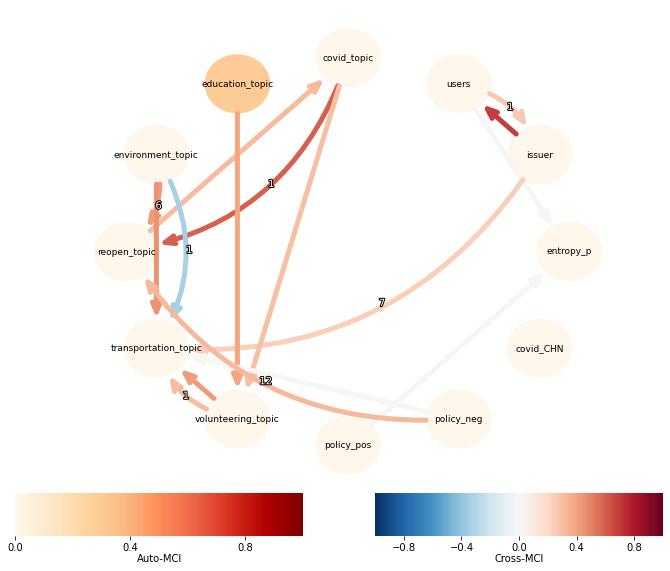

In [14]:
DAG_plot_for_all_diff(df_second_par,independence_test ='parcorr', tau_max =14, 
         NCE_type = 'participate',alpha = 0.1, file_name =None,delete_conflict_links=True,
                      link_name = 'causal_result/p_nce_second_link',p_name = 'causal_result/p_nce_second_p')

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


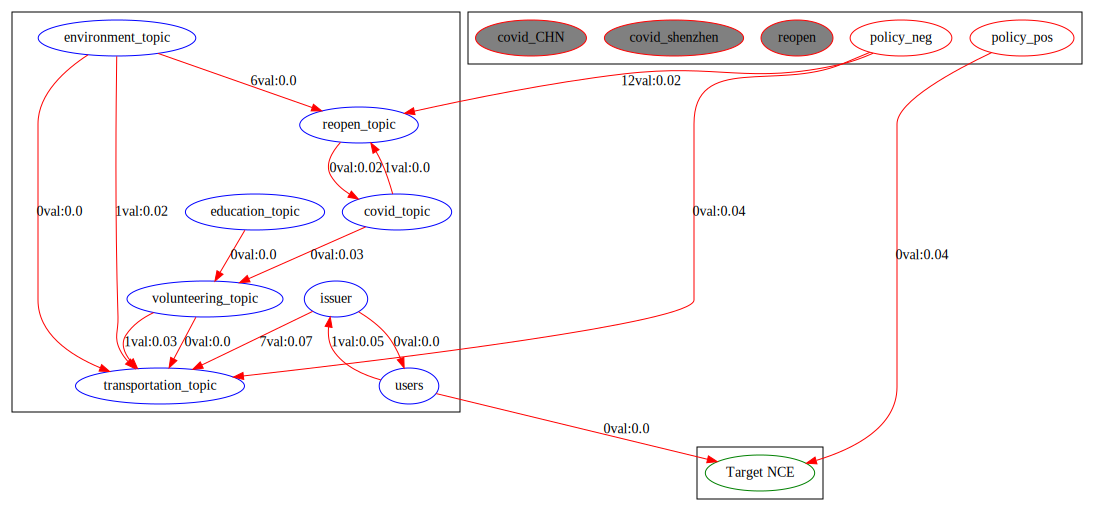

In [15]:
#Full causal graph for the second P-NCE regime
graphviz_plot2(df_second_par,np.load('causal_result/p_nce_second_link.npy'),np.load('causal_result/p_nce_second_p.npy'), filename = None)

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
selected_links = {0: [(1, 0), (1, -1), (1, -2), (1, -3), (1, -4), (1, -5), (1, -6), (1, -7), (1, -8), (1, -9), (1, -10), (1, -11), (1, -12), (1, -13), (1, -14), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4), (2, -5), (2, -6), (2, -7), (2, -8), (2, -9), (2, -10), (2, -11), (2, -12), (2, -13), (2, -14), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4), (3, -5), (3, -6), (3, -7), (3, -8), (3, -9), (3, -10), (3, -11), (3, -12), (3, -13), (3, -14), (4, 0), (4, -1), (4, -2), (4, -3), (4, -4), (4, -5), (4, -6), (4, -7), (4, -8), (4, -9), (4, -10), (4, -11), (4, -12), (4, -13), (4, -14), (5, 0), (5, -1), (5, -2), (5, -3), (5, -4), (5, -5), (5, -6), (5, -7), (5, -8), (5, -9), (5, -10), (5, -11), (5, -12), (5, -13), (5, -14), (6, 0), (6, -1), (6, -2), (6, -3), (6, -4), (6, -5), (6, -6), (6, -7), (6, -8), (6, -9), (6, -10), (6, -11), (6, -12), (6, -13), (6, -14), (7, 0), (7, -1), (7, -2), (7, -3), (7, -4), (7, -5), (7, -6), (7, -7), (7, -

    Subset 0: (covid_topic -6)  gives pval = 0.74362 / val = -0.043
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable NCE_t has 31 parent(s):

Testing condition sets of dimension 2:

    Link (policy_pos -5) --> NCE_t (1/31):
    Subset 0: (education_topic -1) (policy_pos -7)  gives pval = 0.00709 / val =  0.347
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (education_topic -1) --> NCE_t (2/31):
    Subset 0: (policy_pos -5) (policy_pos -7)  gives pval = 0.00900 / val =  0.337
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (policy_pos -7) --> NCE_t (3/31):
    Subset 0: (policy_pos -5) (education_topic -1)  gives pval = 0.83246 / val =  0.028
    Non-significance detected.

    Link (users -1) --> NCE_t (4/31):
    Subset 0: (policy_pos -5) (education_topic -1)  gives pval = 0.18747 / val =  0.174
    Still subsets of d

    Subset 0: (users -1)  gives pval = 0.91123 / val =  0.015
    Non-significance detected.

    Link (covid_topic -5) --> issuer (40/87):
    Subset 0: (users -1)  gives pval = 0.25690 / val =  0.149
    Non-significance detected.

    Link (environment_topic -3) --> issuer (41/87):
    Subset 0: (users -1)  gives pval = 0.09587 / val =  0.217
    No conditions of dimension 1 left.

    Link (issuer -4) --> issuer (42/87):
    Subset 0: (users -1)  gives pval = 0.32618 / val =  0.129
    Non-significance detected.

    Link (users -14) --> issuer (43/87):
    Subset 0: (users -1)  gives pval = 0.04639 / val = -0.258
    No conditions of dimension 1 left.

    Link (covid_topic -4) --> issuer (44/87):
    Subset 0: (users -1)  gives pval = 0.24971 / val =  0.151
    Non-significance detected.

    Link (reopen_topic -2) --> issuer (45/87):
    Subset 0: (users -1)  gives pval = 0.63531 / val =  0.062
    Non-significance detected.

    Link (covid_topic -3) --> issuer (46/87):
    Sub

    Subset 0: () gives pval = 0.02688 / val =  0.283
    No conditions of dimension 0 left.

    Link (volunteering_topic -6) --> users (104/154):
    Subset 0: () gives pval = 0.02422 / val =  0.288
    No conditions of dimension 0 left.

    Link (volunteering_topic -7) --> users (105/154):
    Subset 0: () gives pval = 0.24467 / val =  0.151
    Non-significance detected.

    Link (volunteering_topic -8) --> users (106/154):
    Subset 0: () gives pval = 0.44107 / val = -0.100
    Non-significance detected.

    Link (volunteering_topic -9) --> users (107/154):
    Subset 0: () gives pval = 0.04324 / val = -0.260
    No conditions of dimension 0 left.

    Link (volunteering_topic -10) --> users (108/154):
    Subset 0: () gives pval = 0.06041 / val = -0.242
    No conditions of dimension 0 left.

    Link (volunteering_topic -11) --> users (109/154):
    Subset 0: () gives pval = 0.04690 / val = -0.255
    No conditions of dimension 0 left.

    Link (volunteering_topic -12) --> u

    Subset 0: () gives pval = 0.41960 / val = -0.105
    Non-significance detected.

    Link (users -10) --> covid_topic (24/154):
    Subset 0: () gives pval = 0.59044 / val = -0.070
    Non-significance detected.

    Link (users -11) --> covid_topic (25/154):
    Subset 0: () gives pval = 0.25122 / val = -0.149
    Non-significance detected.

    Link (users -12) --> covid_topic (26/154):
    Subset 0: () gives pval = 0.32003 / val = -0.129
    Non-significance detected.

    Link (users -13) --> covid_topic (27/154):
    Subset 0: () gives pval = 0.45438 / val = -0.098
    Non-significance detected.

    Link (users -14) --> covid_topic (28/154):
    Subset 0: () gives pval = 0.02704 / val = -0.283
    No conditions of dimension 0 left.

    Link (covid_topic -1) --> covid_topic (29/154):
    Subset 0: () gives pval = 0.00000 / val =  0.651
    No conditions of dimension 0 left.

    Link (covid_topic -2) --> covid_topic (30/154):
    Subset 0: () gives pval = 0.00213 / val =  0.3

    Subset 0: (reopen_topic -6) (covid_topic -6)  gives pval = 0.15515 / val =  0.187
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (volunteering_topic -9) --> covid_topic (32/32):
    Subset 0: (reopen_topic -6) (covid_topic -6)  gives pval = 0.11982 / val = -0.205
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable covid_topic has 19 parent(s):
        (covid_topic -1): max_pval = 0.00415, min_val =  0.365
        (covid_topic -14): max_pval = 0.00480, min_val =  0.359
        (transportation_topic -14): max_pval = 0.01042, min_val =  0.328
        (volunteering_topic -14): max_pval = 0.02919, min_val =  0.284
        (environment_topic -14): max_pval = 0.03868, min_val =  0.265
        (transportation_topic -13): max_pval = 0.05786, min_val =  0.246
        (users -14): max_pval = 0.06312, min_val =  0.243
      

    Subset 0: (education_topic -1)  gives pval = 0.00998 / val =  0.330
    No conditions of dimension 1 left.

    Link (environment_topic -3) --> education_topic (32/85):
    Subset 0: (education_topic -1)  gives pval = 0.53142 / val =  0.082
    Non-significance detected.

    Link (issuer -6) --> education_topic (33/85):
    Subset 0: (education_topic -1)  gives pval = 0.08649 / val =  0.223
    No conditions of dimension 1 left.

    Link (policy_pos -11) --> education_topic (34/85):
    Subset 0: (education_topic -1)  gives pval = 0.04980 / val =  0.254
    No conditions of dimension 1 left.

    Link (issuer -5) --> education_topic (35/85):
    Subset 0: (education_topic -1)  gives pval = 0.10249 / val =  0.213
    No conditions of dimension 1 left.

    Link (policy_pos -6) --> education_topic (36/85):
    Subset 0: (education_topic -1)  gives pval = 0.27803 / val =  0.142
    Non-significance detected.

    Link (environment_topic -7) --> education_topic (37/85):
    Subset 0:

    Subset 0: () gives pval = 0.95948 / val = -0.007
    Non-significance detected.

    Link (covid_CHN -5) --> environment_topic (145/154):
    Subset 0: () gives pval = 0.57420 / val =  0.073
    Non-significance detected.

    Link (covid_CHN -6) --> environment_topic (146/154):
    Subset 0: () gives pval = 0.97947 / val = -0.003
    Non-significance detected.

    Link (covid_CHN -7) --> environment_topic (147/154):
    Subset 0: () gives pval = 0.78968 / val =  0.035
    Non-significance detected.

    Link (covid_CHN -8) --> environment_topic (148/154):
    Subset 0: () gives pval = 0.95223 / val = -0.008
    Non-significance detected.

    Link (covid_CHN -9) --> environment_topic (149/154):
    Subset 0: () gives pval = 0.21788 / val = -0.160
    Non-significance detected.

    Link (covid_CHN -10) --> environment_topic (150/154):
    Subset 0: () gives pval = 0.62909 / val =  0.063
    Non-significance detected.

    Link (covid_CHN -11) --> environment_topic (151/154):
    

    Subset 0: () gives pval = 0.27245 / val = -0.143
    Non-significance detected.

    Link (environment_topic -14) --> reopen_topic (70/154):
    Subset 0: () gives pval = 0.00469 / val = -0.357
    No conditions of dimension 0 left.

    Link (reopen_topic -1) --> reopen_topic (71/154):
    Subset 0: () gives pval = 0.00109 / val =  0.408
    No conditions of dimension 0 left.

    Link (reopen_topic -2) --> reopen_topic (72/154):
    Subset 0: () gives pval = 0.17446 / val =  0.176
    No conditions of dimension 0 left.

    Link (reopen_topic -3) --> reopen_topic (73/154):
    Subset 0: () gives pval = 0.00616 / val =  0.347
    No conditions of dimension 0 left.

    Link (reopen_topic -4) --> reopen_topic (74/154):
    Subset 0: () gives pval = 0.06450 / val =  0.238
    No conditions of dimension 0 left.

    Link (reopen_topic -5) --> reopen_topic (75/154):
    Subset 0: () gives pval = 0.08334 / val =  0.224
    No conditions of dimension 0 left.

    Link (reopen_topic -6) 

    Subset 0: (covid_topic -1) (environment_topic -6) (covid_topic -6)  gives pval = 0.02088 / val = -0.303
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (environment_topic -2) --> reopen_topic (16/17):
    Subset 0: (covid_topic -1) (environment_topic -6) (covid_topic -6)  gives pval = 0.10352 / val = -0.216
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (transportation_topic -1) --> reopen_topic (17/17):
    Subset 0: (covid_topic -1) (environment_topic -6) (covid_topic -6)  gives pval = 0.05410 / val = -0.254
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable reopen_topic has 9 parent(s):
        (covid_topic -1): max_pval = 0.00087, min_val =  0.419
        (transportation_topic -14): max_pval = 0.07726, min_val =  0.232
        (policy_neg -12): max_pval = 0.09467, min_val =  0.220
   

    Subset 0: (volunteering_topic -1)  gives pval = 0.47265 / val =  0.094
    Non-significance detected.

    Link (transportation_topic -8) --> transportation_topic (68/75):
    Subset 0: (volunteering_topic -1)  gives pval = 0.41654 / val =  0.107
    Non-significance detected.

    Link (environment_topic -4) --> transportation_topic (69/75):
    Subset 0: (volunteering_topic -1)  gives pval = 0.88508 / val = -0.019
    Non-significance detected.

    Link (policy_pos -1) --> transportation_topic (70/75):
    Subset 0: (volunteering_topic -1)  gives pval = 0.70150 / val = -0.051
    Non-significance detected.

    Link (reopen_topic -3) --> transportation_topic (71/75):
    Subset 0: (volunteering_topic -1)  gives pval = 0.57355 / val = -0.074
    Non-significance detected.

    Link (policy_neg -5) --> transportation_topic (72/75):
    Subset 0: (volunteering_topic -1)  gives pval = 0.06278 / val = -0.242
    No conditions of dimension 1 left.

    Link (volunteering_topic -14) --

    Subset 0: (volunteering_topic -1)  gives pval = 0.33100 / val = -0.128
    Non-significance detected.

    Link (education_topic -2) --> volunteering_topic (12/76):
    Subset 0: (volunteering_topic -1)  gives pval = 0.62408 / val =  0.065
    Non-significance detected.

    Link (volunteering_topic -6) --> volunteering_topic (13/76):
    Subset 0: (volunteering_topic -1)  gives pval = 0.00414 / val =  0.365
    No conditions of dimension 1 left.

    Link (issuer -2) --> volunteering_topic (14/76):
    Subset 0: (volunteering_topic -1)  gives pval = 0.67150 / val =  0.056
    Non-significance detected.

    Link (volunteering_topic -2) --> volunteering_topic (15/76):
    Subset 0: (volunteering_topic -1)  gives pval = 0.63665 / val = -0.062
    Non-significance detected.

    Link (environment_topic -6) --> volunteering_topic (16/76):
    Subset 0: (volunteering_topic -1)  gives pval = 0.00594 / val =  0.351
    No conditions of dimension 1 left.

    Link (users -2) --> volunteer

    Subset 0: () gives pval = 0.00000 / val =  0.725
    No conditions of dimension 0 left.

    Link (environment_topic  0) o-o education_topic (59/129):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (education_topic -1) (education_topic -6) (education_topic -14) ]
    with conds_x = [ (reopen_topic -6) (volunteering_topic -1) (covid_topic -1) (environment_topic -14) ]
    Subset 0: () gives pval = 0.00000 / val =  0.579
    No conditions of dimension 0 left.

    Link (environment_topic -14) --> environment_topic (60/129):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (reopen_topic -6) (volunteering_topic -1) (covid_topic -1) ]
    with conds_x = [ (reopen_topic -20) (volunteering_topic -15) (covid_topic -15) (environment_topic -28) ]
    Subset 0: () gives pval = 0.01382 / val = -0.333
    No conditions of dimension 0 left.

    Link (environment_topic  0) o-o reopen_topic (61/129):
    Iterate through 1 subset(s) of conditions: 
    wit

    Subset 2: (volunteering_topic 0)  gives pval = 0.00007 / val =  0.518
    Subset 3: (issuer 0)  gives pval = 0.00001 / val =  0.576
    Subset 4: (users 0)  gives pval = 0.00001 / val =  0.581
    No conditions of dimension 1 left.

    Link (covid_topic  0) o-o transportation_topic (32/93):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ (volunteering_topic -1) (issuer -7) (transportation_topic -14) (environment_topic -1) (education_topic -1) ]
    with conds_x = [ (covid_topic -1) (covid_topic -14) (covid_topic -7) (covid_CHN -8) ]
    Subset 0: (environment_topic 0)  gives pval = 0.01282 / val =  0.346
    Subset 1: (volunteering_topic 0)  gives pval = 0.38919 / val =  0.123
    Non-significance detected.

    Link (covid_topic  0) o-o volunteering_topic (33/93):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ (volunteering_topic -1) (education_topic -5) (policy_pos -5) (covid_topic -14) (transportation_topic -1) ]
    with conds_x = [ (

    Subset 0: (issuer 0)  gives pval = 0.18046 / val = -0.183
    Subset 1: (education_topic 0)  gives pval = 0.35671 / val = -0.127
    Non-significance detected.

    Link (covid_CHN -8) --> covid_topic (90/93):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ (covid_topic -1) (covid_topic -14) (covid_topic -7) ]
    with conds_x = [ ]
    Subset 0: (volunteering_topic 0)  gives pval = 0.04925 / val = -0.262
    Subset 1: (environment_topic 0)  gives pval = 0.00937 / val = -0.341
    Subset 2: (transportation_topic 0)  gives pval = 0.03221 / val = -0.284
    Subset 3: (education_topic 0)  gives pval = 0.02210 / val = -0.303
    Subset 4: (issuer 0)  gives pval = 0.02082 / val = -0.306
    Subset 5: (reopen_topic 0)  gives pval = 0.00504 / val = -0.367
    Subset 6: (users 0)  gives pval = 0.03740 / val = -0.276
    No conditions of dimension 1 left.

    Link (covid_CHN  0) o-o environment_topic (91/93):
    Iterate through 7 subset(s) of conditions: 
    with con

    Subset 0: () gives pval = 0.27808 / val =  0.152
    Subset 1: (users 0)  gives pval = 0.11853 / val = -0.219
    Fraction of separating subsets containing (users 0) is < 0.5 --> collider found

    Triple (education_topic -14) --> users o-o issuer (2/57)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (users -1) (covid_CHN -5) (reopen_topic -6) ]
    with conds_x = [ (education_topic -15) (education_topic -20) (education_topic -28) ]
    Subset 0: () gives pval = 0.24619 / val = -0.159
    Subset 1: (users 0)  gives pval = 0.28233 / val =  0.149
    Fraction of separating subsets containing (users 0) is = 0.5 --> ambiguous triple found

    Triple (users -1) --> issuer o-o users (3/57)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (education_topic -14) (issuer -14) (education_topic -4) (environment_topic -6) ]
    with conds_x = [ (education_topic -15) (users -2) (issuer -15) (education_topic -5) (environment_topic -7) 

    Subset 2: () gives pval = 0.03120 / val =  0.302
    Subset 3: (covid_topic 0) (education_topic 0)  gives pval = 0.74989 / val = -0.047
    Subset 4: (education_topic 0) (transportation_topic 0)  gives pval = 0.15997 / val =  0.204
    Subset 5: (covid_topic 0) (education_topic 0) (transportation_topic 0)  gives pval = 0.40739 / val =  0.122
    Subset 6: (transportation_topic 0)  gives pval = 0.00374 / val =  0.403
    Subset 7: (covid_topic 0) (transportation_topic 0)  gives pval = 0.03367 / val =  0.304
    Fraction of separating subsets containing (covid_topic 0) is > 0.5 --> non-collider found

    Triple (covid_CHN -8) --> covid_topic o-o reopen_topic (38/57)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (covid_topic -1) (transportation_topic -14) (policy_neg -12) (covid_topic -2) (environment_topic -6) ]
    with conds_x = [ ]
    Subset 0: (education_topic 0)  gives pval = 0.32814 / val =  0.134
    Subset 1: (covid_topic 0)  gives pval = 0.0

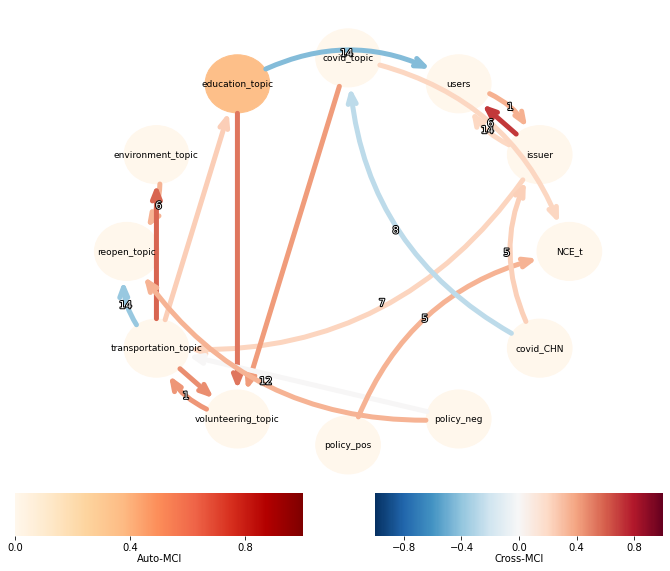

In [16]:
DAG_plot_for_all_diff(df_first_tt,independence_test ='parcorr', tau_max =14, 
         NCE_type = 'tasktype',alpha = 0.2, file_name =None, delete_conflict_links=True,
                      link_name = 'causal_result/t_nce_first_link',p_name = 'causal_result/t_nce_first_p')

C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
C:\Users\11758\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


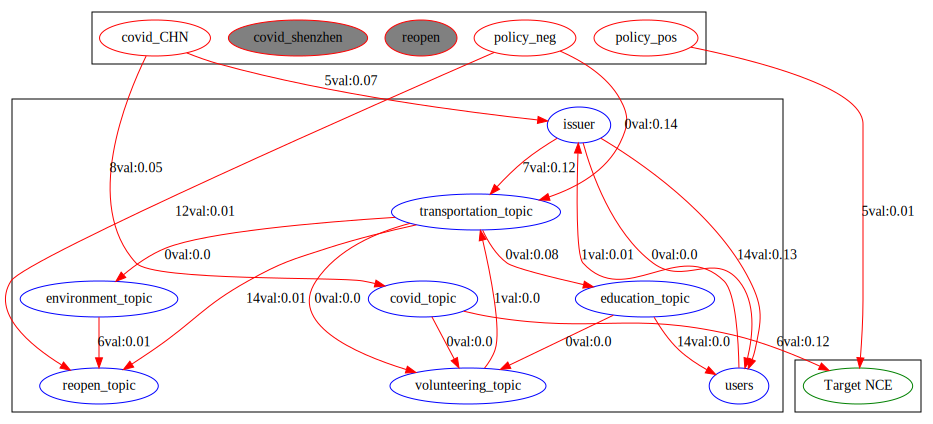

In [17]:
#Full causal graph for the first T-NCE regime
graphviz_plot2(df_first_tt,np.load('causal_result/t_nce_first_link.npy'),np.load('causal_result/t_nce_first_p.npy'), filename = None)